In the previous notebook, I used Faster R-CNN model for object detection task. The evaluation metrics and inference results indicated that there’s still room for improvement. Therefore, in this notebook, I’d like to compare how YOLOv5 model performs on the same dataset and task.

### Experiment 2: YOLOv5

#### YOLOv5 under three minutes
From the [documentation of YOLOv5](https://docs.ultralytics.com/yolov5/tutorials/architecture_description/) and [this medium post](https://sh-tsang.medium.com/brief-review-yolov5-for-object-detection-84cc6c6a0e3a) which refers to [this paper](https://www.mdpi.com/1424-8220/22/15/5817), the architecture of YOLOv5 consists of three main components: backbone, neck, and head. The backbone serves as the network’s main body and is constructed using the CSP-Darknet53 structure. The main structure is a stack of multiple CBS (Conv + BatchNorm + SiLU) modules and C3 modules, with a connection to an SPPF module. The CBS module assists the C3 module in feature extraction, while the SPPF module enhances the backbone’s feature expression ability. The neck, which links the backbone and the head, uses FPN and PAN methods. The basic concept of FPN is to up-sampling the output feature map produced by multiple convolution down sampling operations from the feature extraction network to generate multiple new feature maps for detecting targets of different scales. PAN introduces a new bottom-up feature fusion path, which further improves the detection accuracy for objects of different scales. The head is responsible for the final output, where bounding-box regression takes place. Bounding-box regression is the adjustment of the center coordinate and size of the preset prior anchor to the center coordinate and size of the final prediction box.

The YOLOv5 algorithm works by processing the image to be detected through an input layer and sending it to the backbone for feature extraction. The backbone obtains feature maps of varying sizes, which are then fused these features through the feature fusion network (neck) to generate three feature maps P3, P4, and P5 for detecting small, medium, and large objects in the image, respectively. Once the three feature maps are sent to the prediction head, the confidence calculation and bounding-box regression are performed for each pixel in the feature map using the preset prior anchor, resulting in a multi-dimensional array (BBoxes) that include object class, class confidence, box coordinates, width, and height information. By setting the corresponding thresholds to filter out unnecessary information in the array and performing a non-maximum suppression process, the final detection information can be output.

#### References
[Ultralytics YOLOv5 Architecture](https://docs.ultralytics.com/yolov5/tutorials/architecture_description/) \
[Brief Review: YOLOv5 for Object Detection](https://sh-tsang.medium.com/brief-review-yolov5-for-object-detection-84cc6c6a0e3a) \
[SF-YOLOv5: A Lightweight Small Object Detection Algorithm Based on Improved Feature Fusion Mode](https://www.mdpi.com/1424-8220/22/15/5817) \
[Train Custom Data with YOLOv5](https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/) \
[PASCAL VOC XML to YOLO Conversion](https://medium.com/@oliver.lovstrom/pascal-voc-xml-to-yolo-conversion-a-comprehensive-python-guide-eac3838d30bb) \
[Object Detection Metrics](https://github.com/rafaelpadilla/Object-Detection-Metrics)

#### Implementation
I will refer to [this website](https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/) for running object detection with YOLOv5. Let’s get started.

Before we start, we need to clone repo and install the requirements from the latest YOLOv5 release. Note that the YOLOv5 assumes the dataset directory is inside a directory next to the YOLOv5 directory.

In [1]:
import os

os.getcwd()

'D:\\personal\\self-learn\\data-dataan\\playground'

In [2]:
os.chdir('..')
os.getcwd()

'D:\\personal\\self-learn\\data-dataan'

In [ ]:
!git clone https://github.com/ultralytics/yolov5

In [4]:
os.chdir('yolov5')
!pip install -r requirements.txt

     ---------------------------------------- 0.0/40.7 kB ? eta -:--:--
     ------------------- ------------------ 20.5/40.7 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 40.7/40.7 kB 483.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
    --------------------------------------- 0.1/2.5 MB 3.4 MB/s eta 0:00:01
   --- ------------------------------------ 0.2/2.5 MB 2.5 MB/s eta 0:00:01
   ---- ----------------------------------- 0.3/2.5 MB 2.1 MB/s eta 0:00:02
   ----- ---------------------------------- 0.3/2.5 MB 1.9 MB/s eta 0:00:02
   ----- ---------------------------------- 0.4/2.5 MB 1.8 MB/s eta 0:00:02
   ----- ---------------------------------- 0.4/2.5 MB 1.8 MB/s eta 0:00:02
   ----- ---------------------------------- 0.4/2.5 MB 1.8 MB/s eta 0:00:02
   ----- ---------------------------------- 0.4/2.5 MB 1.8 MB/s eta 0:00:02
   ------ --------------------------------- 0.4/2.5 MB 971.5 kB/s eta 0:00:03
   ------ ---

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chartify 4.0.2 requires pandas<2.0.0,>=1.2.0, but you have pandas 2.1.4 which is incompatible.
panel 1.3.8 requires bokeh<3.4.0,>=3.2.0, but you have bokeh 3.1.0 which is incompatible.


YOLOv5 models must be trained on YOLO format data in order to learn classes of objects in that data. We need to create a YOLOv5 YAML configuration file that defines the dataset root directory path and relative paths to train, val, and test image directories and a class names dictionary.

In [5]:
import yaml

data = {
    'path': '../datasets/road-sign-detection-v2/split-data',
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'names': {
        0: 'trafficlight',
        1: 'stop',
        2: 'speedlimit',
        3: 'crosswalk'
    }
}

with open('../yolov5/data/road-sign-detection.yaml', 'w') as f:
    yaml.dump(data, f, default_flow_style=False)

After creating YAML file, we need to convert the XML annotations to YOLO format, with one *.txt file per image with these specifications:

- One row per object
- Each row is class x_center y_center width height format
- Box coordinates must be in normalized xywh format (from 0 to 1). If the boxes are in pixels, divide x_center and width by image width, and y_center and height by image height
- Class numbers are zero-indexed (start from 0)

I u[tilize th](https://medium.com/@oliver.lovstrom/pascal-voc-xml-to-yolo-conversion-a-comprehensive-python-guide-eac3838d30bb)is code to create the labels.

In [9]:
import xml.etree.ElementTree as ET
import argparse

def convert_bbox(size: tuple[float, float], box: tuple[float, float, float, float]) -> tuple[float, float, float, float]:
    scale_width = 1.0 / size[0]
    scale_height = 1.0 / size[1]

    center_x = (box[0] + box[2]) / 2.0
    center_y = (box[1] + box[3]) / 2.0
    box_width = box[2] - box[0]
    box_height = box[3] - box[1]

    rel_center_x = center_x * scale_width
    rel_center_y = center_y * scale_height
    rel_width = box_width * scale_width
    rel_height = box_height * scale_height

    return (rel_center_x, rel_center_y, rel_width, rel_height)

The function accepts the width and height of the image and the bounding box coordinates of the object in the image. First it calculates the scale of the width and height of the image. Next, it calculates the center of the bounding box (center_x and center_y) as well as the width and height of the bounding box (box_width and box_height). Then, it calculates the relative center, width, and height of the bounding box by multiplying the absolute values by the corresponding scale. Finally, it returns these relative values.

Next, define a function to extract the information in XML and write it to txt.

In [14]:
def convert_xml(input_xml:str, output_txt: str, class_mapping: dict[str, int]):
    tree = ET.parse(input_xml)
    root = tree.getroot()
    width = int(root.find(".//size/width").text)
    height = int(root.find(".//size/height").text)

    with open(output_txt, 'w', encoding="utf-8") as f:
        for obj in root.iter("object"):
            cell_name = obj.find("name").text
            cell_id = class_mapping.get(cell_name, -1)
            
            if cell_id == -1:
                continue
            
            xmlbox = obj.find("bndbox")
            box = (
                float(xmlbox.find("xmin").text),
                float(xmlbox.find("ymin").text),
                float(xmlbox.find("xmax").text),
                float(xmlbox.find("ymax").text)
            )
            bbox = convert_bbox((width, height), box)
            f.write(f"{cell_id} {' '.join([str(a) for a in bbox])}\n")

This function accepts the path to the XML file, path to the output txt file, and dictionary of class names and class ID. First it parses the XML file and then gets the root element of the XML tree. Next, it retrieves the width and height of the image from the XML file. For each object in the XML file, it retrieves the name of the object and maps it to the corresponding class ID, the bounding box of the object, call the convert_bbox function and pass the bounding box obtained, and writes the result to the output txt file.

After defining both functions, put them altogether and run the function for the annotations in the train, val, and test directories.

In [15]:
def xml_to_yolo(input_dir: str, output_dir: str) -> None:
    class_mapping = {
        "trafficlight": 0,
        "stop": 1,
        "speedlimit": 2,
        "crosswalk": 3
    }
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for xml_file in os.listdir(input_dir):
        if xml_file.endswith(".xml"):
            input_xml_path = os.path.join(input_dir, xml_file)
            output_txt_path = os.path.join(output_dir, xml_file.replace(".xml", ".txt"))
            convert_xml(input_xml_path, output_txt_path, class_mapping)

In [16]:
TRAIN_ANNO = '../datasets/road-sign-detection-v2/split-data/train/annotations'
TRAIN_TXT = '../datasets/road-sign-detection-v2/split-data/train/labels'
print("Converting training annotations...")
xml_to_yolo(TRAIN_ANNO, TRAIN_TXT)
print("Training annotations finished")

VAL_ANNO = '../datasets/road-sign-detection-v2/split-data/val/annotations'
VAL_TXT = '../datasets/road-sign-detection-v2/split-data/val/labels'
print("Converting validation annotations...")
xml_to_yolo(VAL_ANNO, VAL_TXT)
print("Validation annotations finished")

TEST_ANNO = '../datasets/road-sign-detection-v2/split-data/test/annotations'
TEST_TXT = '../datasets/road-sign-detection-v2/split-data/test/labels'
print("Converting test annotations...")
xml_to_yolo(TEST_ANNO, TEST_TXT)
print("Test annotations finished")

Converting training annotations...
Training annotations finished
Converting validation annotations...
Validation annotations finished
Converting test annotations...
Test annotations finished


In [18]:
test_file = f"{TRAIN_TXT}/road0.txt"
f = open(test_file, "r")
print(f.read())
f.close()

0 0.5730337078651685 0.3675 0.41198501872659177 0.425



Train a YOLOv5 model on the data by specifying dataset, batch size, weights, epochs, and early stopping patience.

In [4]:
WEIGHTS = 'yolov5s.pt'
DATA = 'road-sign-detection.yaml'
EPOCHS = 20
BATCH_SIZE = 8
PATIENCE = 5

!python train.py --batch {BATCH_SIZE} --epochs {EPOCHS} --data {DATA} --weights {WEIGHTS} --patience {PATIENCE}

train: weights=yolov5s.pt, cfg=, data=road-sign-detection.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=20, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=5, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-312-g1bcd17ee Python-3.9.18 torch-2.2.0+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, io

The training results are saved to runs/train/ directory. This directory contains train and validation statistics, as well as metrics and charts including precision-recall (PR) curves and confusion matrix.

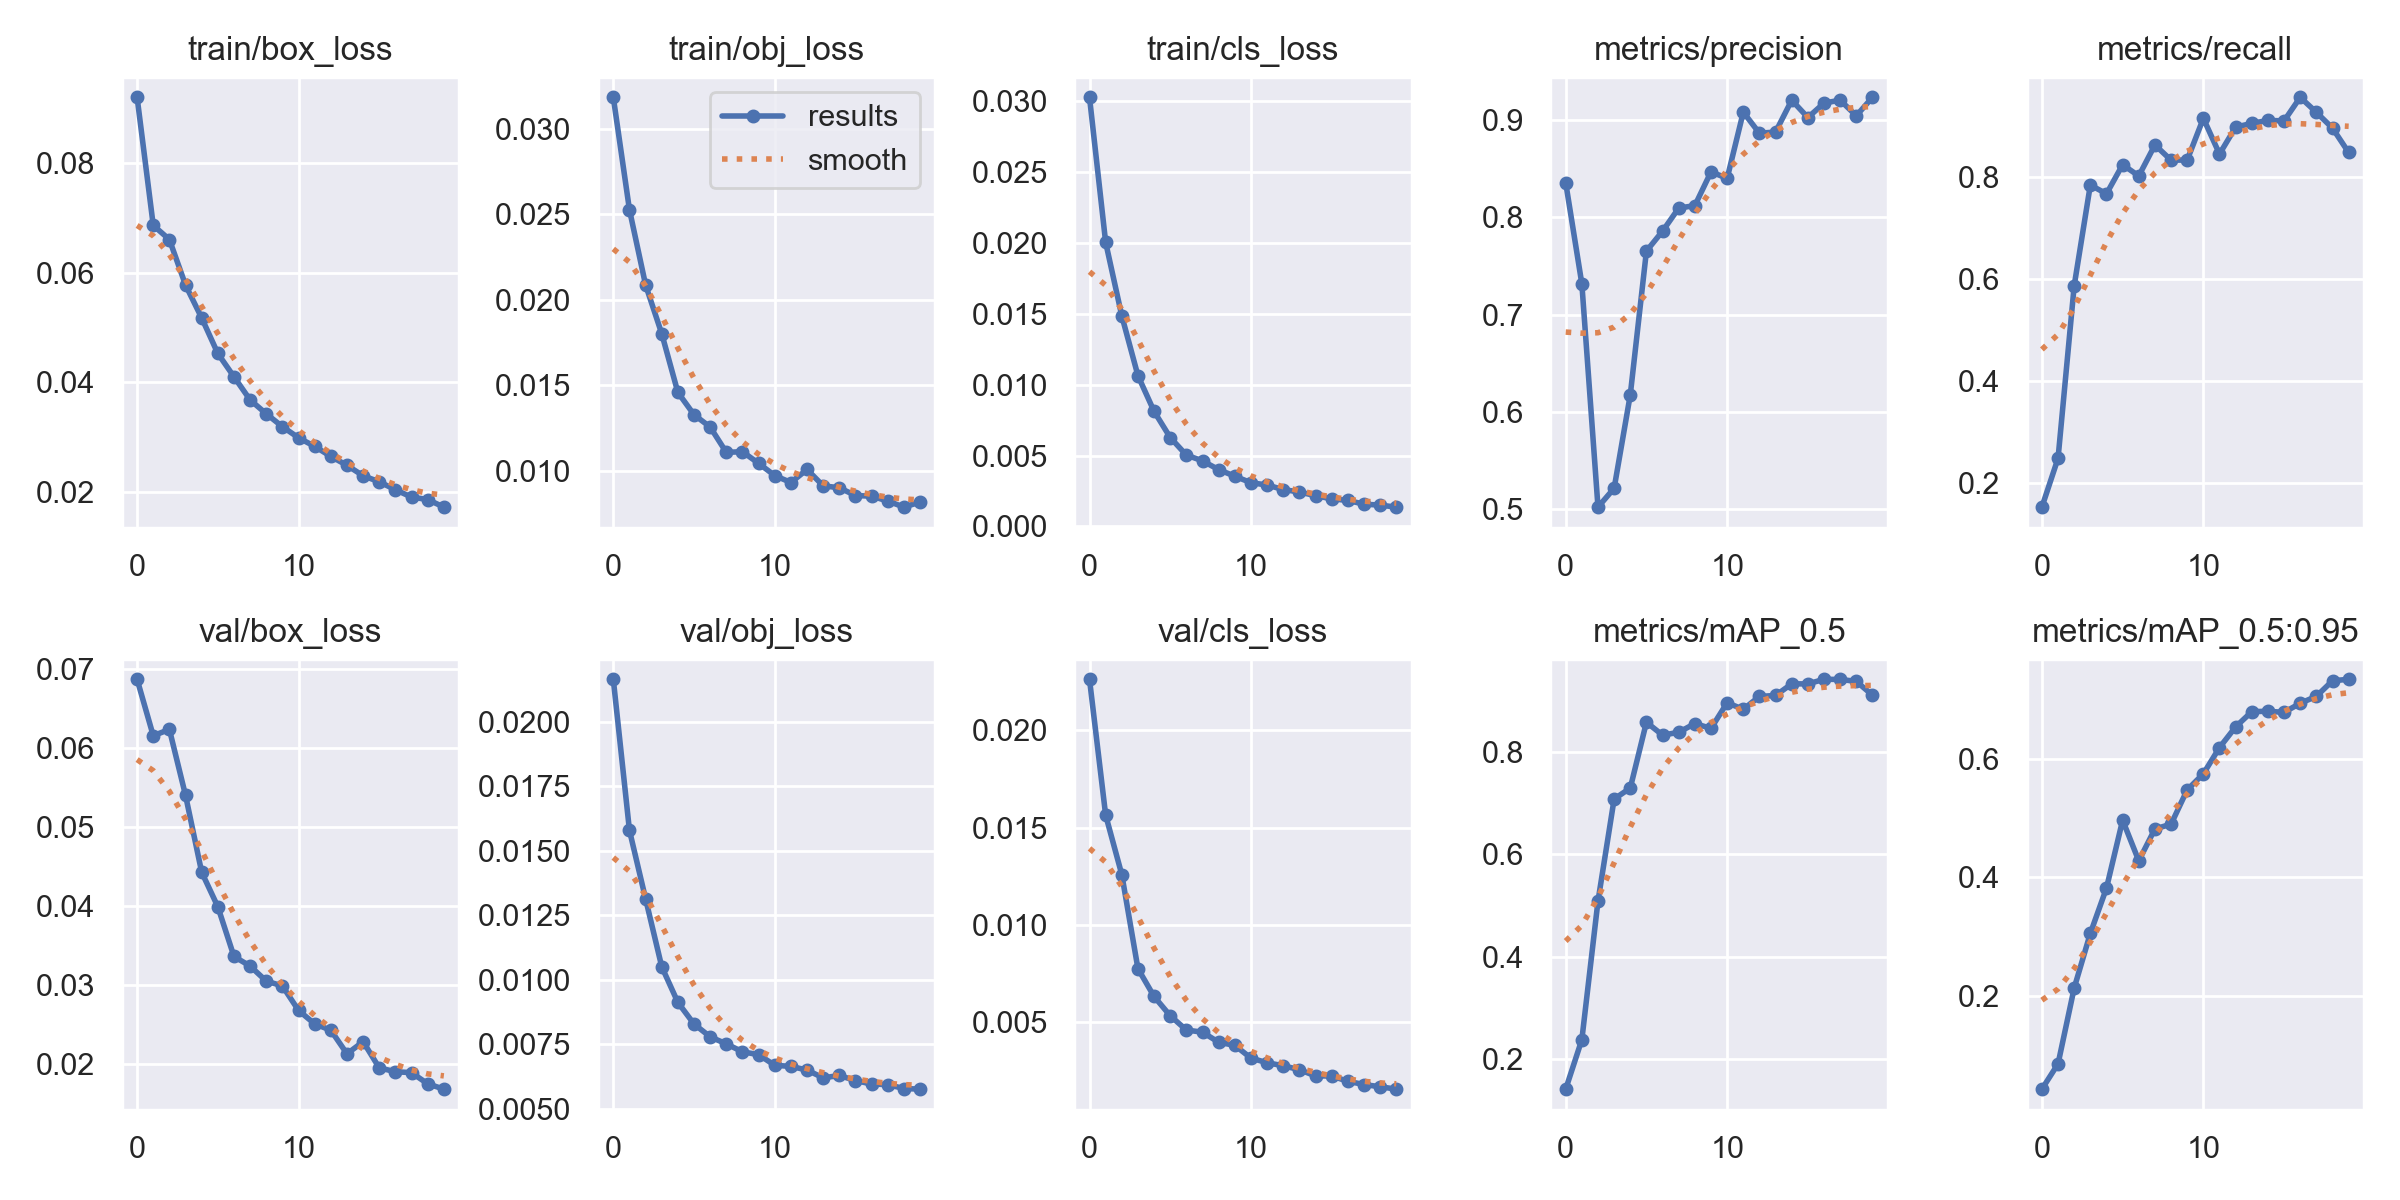

In [6]:
from IPython.display import Image

result_plot = "./runs/train/exp/results.png"
display(Image(filename=result_plot))

The x-axis in the plots represents the epochs of training, that is 20. As the training progresses, the losses decrease and the performance metrics increase. There’s three losses being computed (box_loss, obj_loss, and cls_loss) because the model predicts the box coordinates, the object class, and the class confidence, so it also computes the losses regarding the prediction objective. The plots for training and validation loss show the loss values during training and validation. The decreasing trend in these plots indicates that the model’s predictions are improving gradually. The plots for metrics show the performance of the model. The increasing trend in these plots indicates that the model’s ability to correctly identify objects (precision), its ability to find all relevant objects, and its overall precision are improving over time.

Metric: confusion_matrix


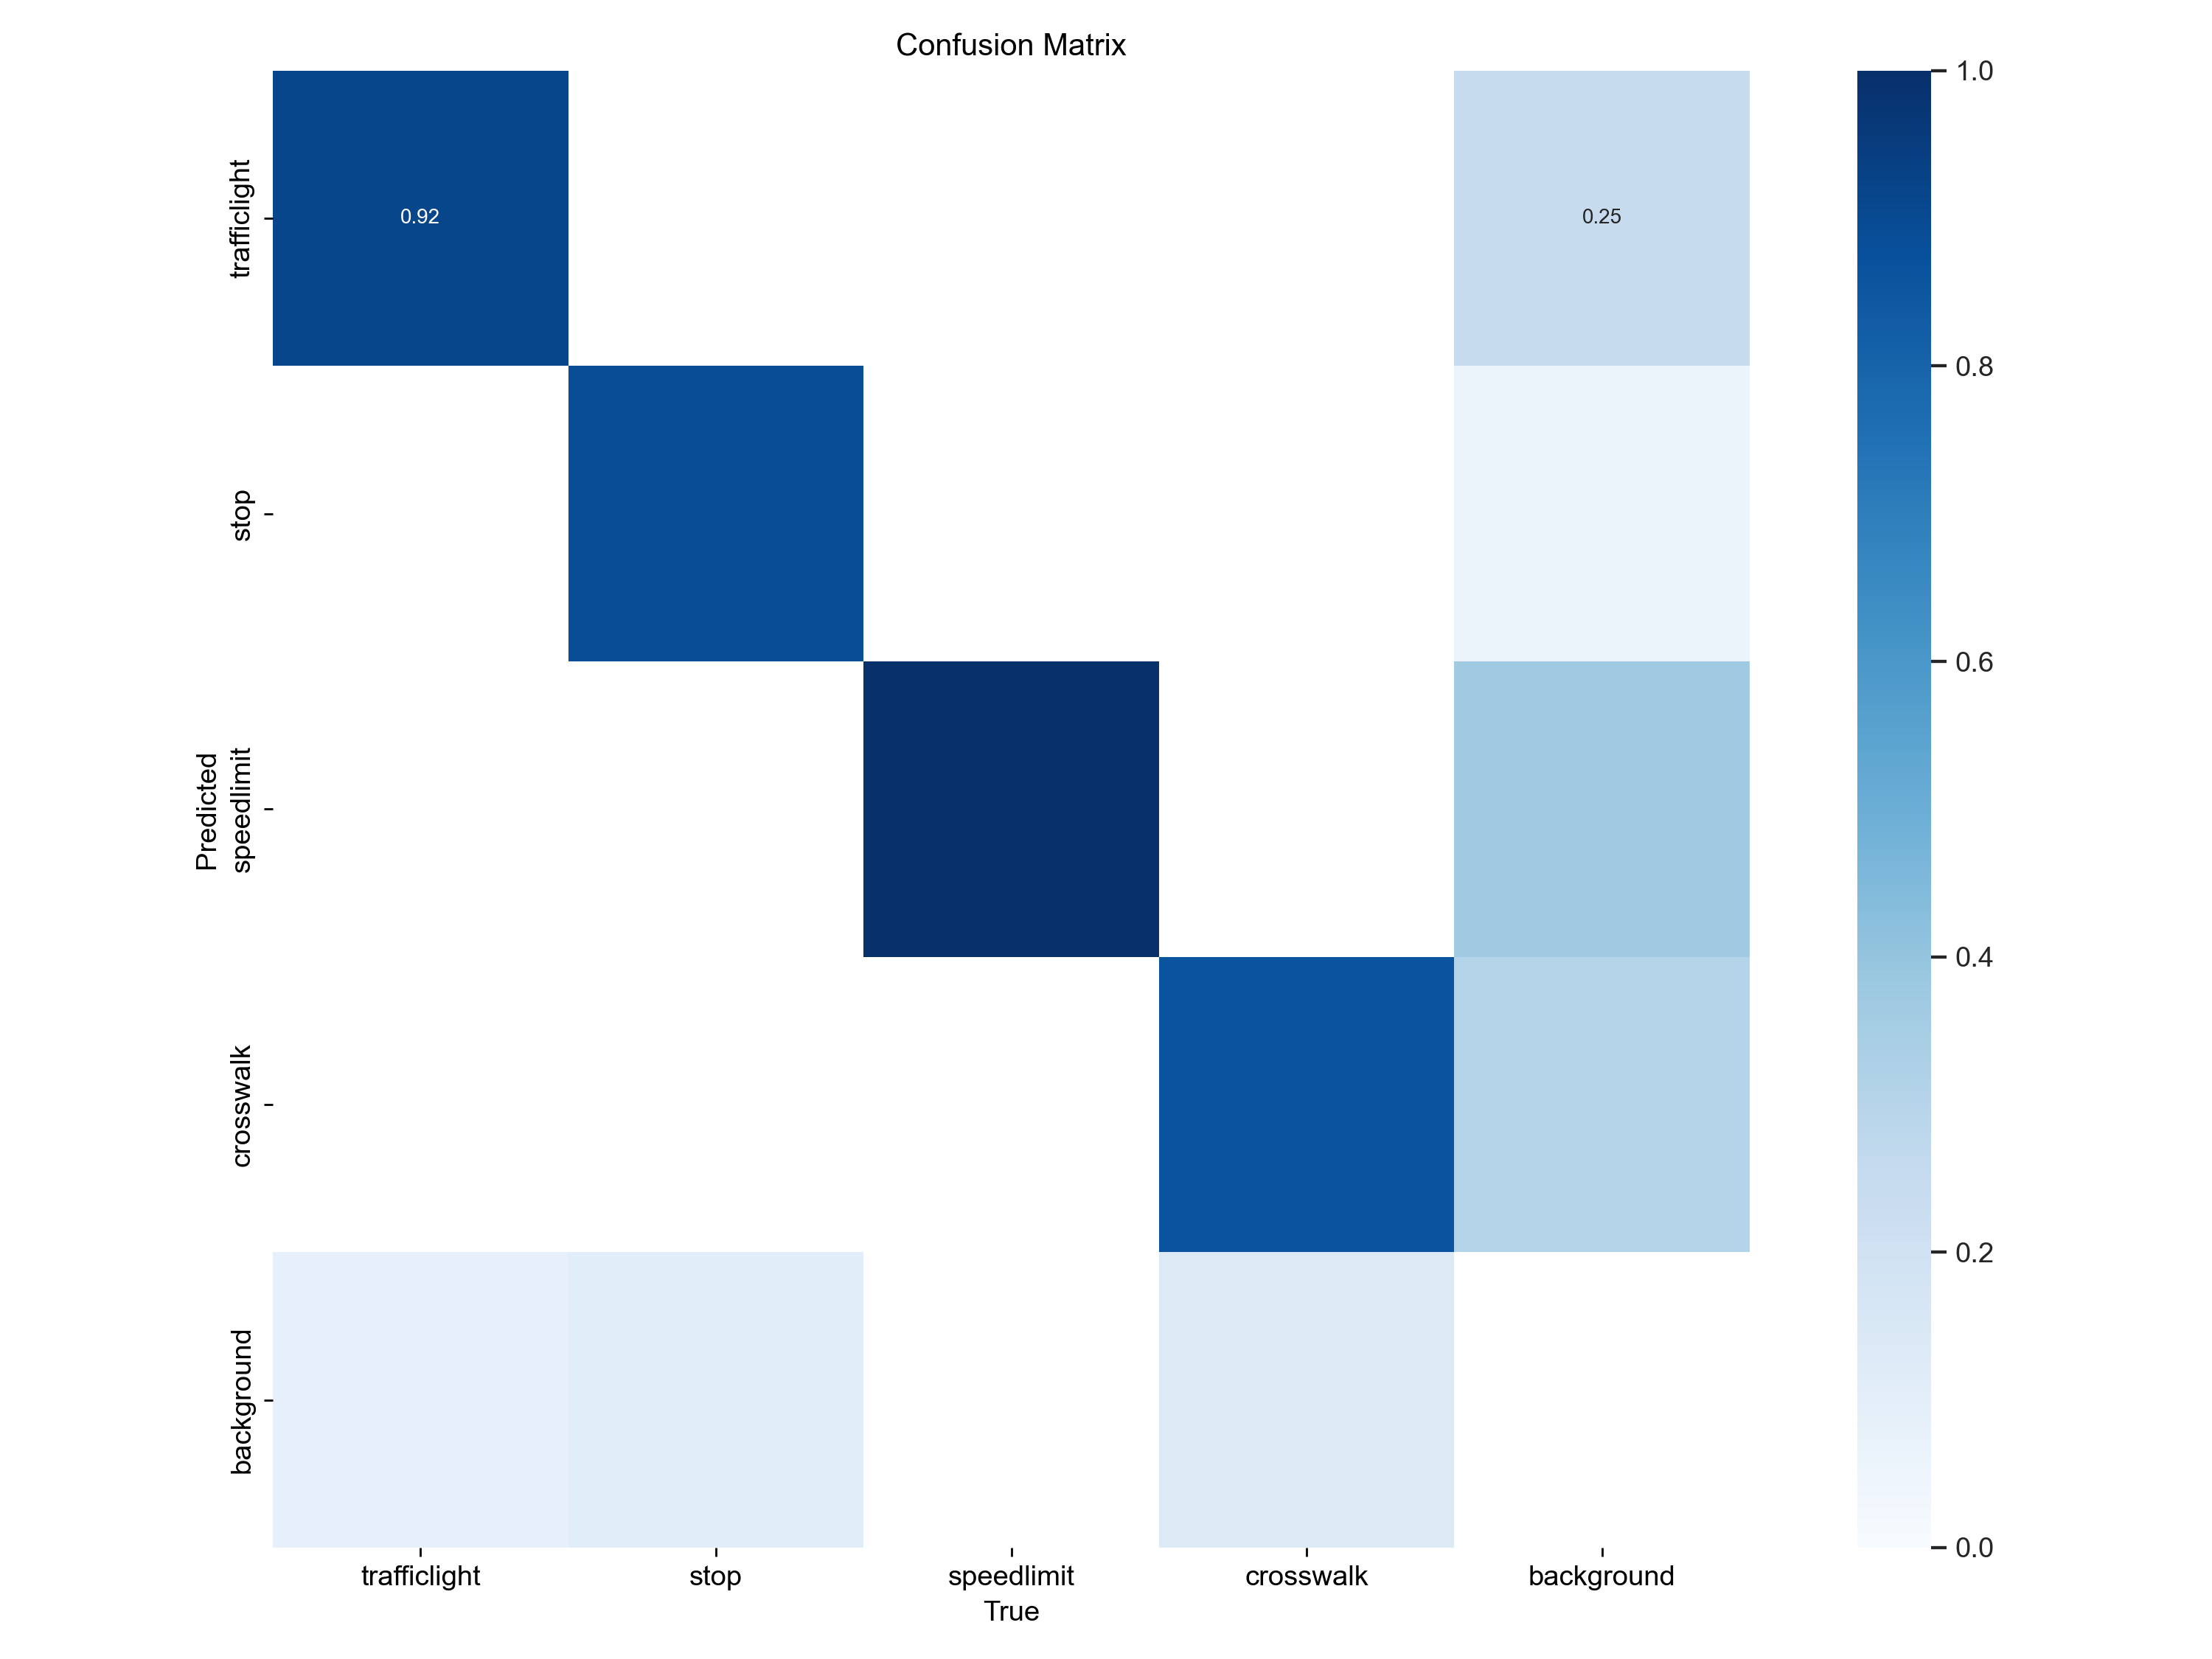

Metric: F1_curve


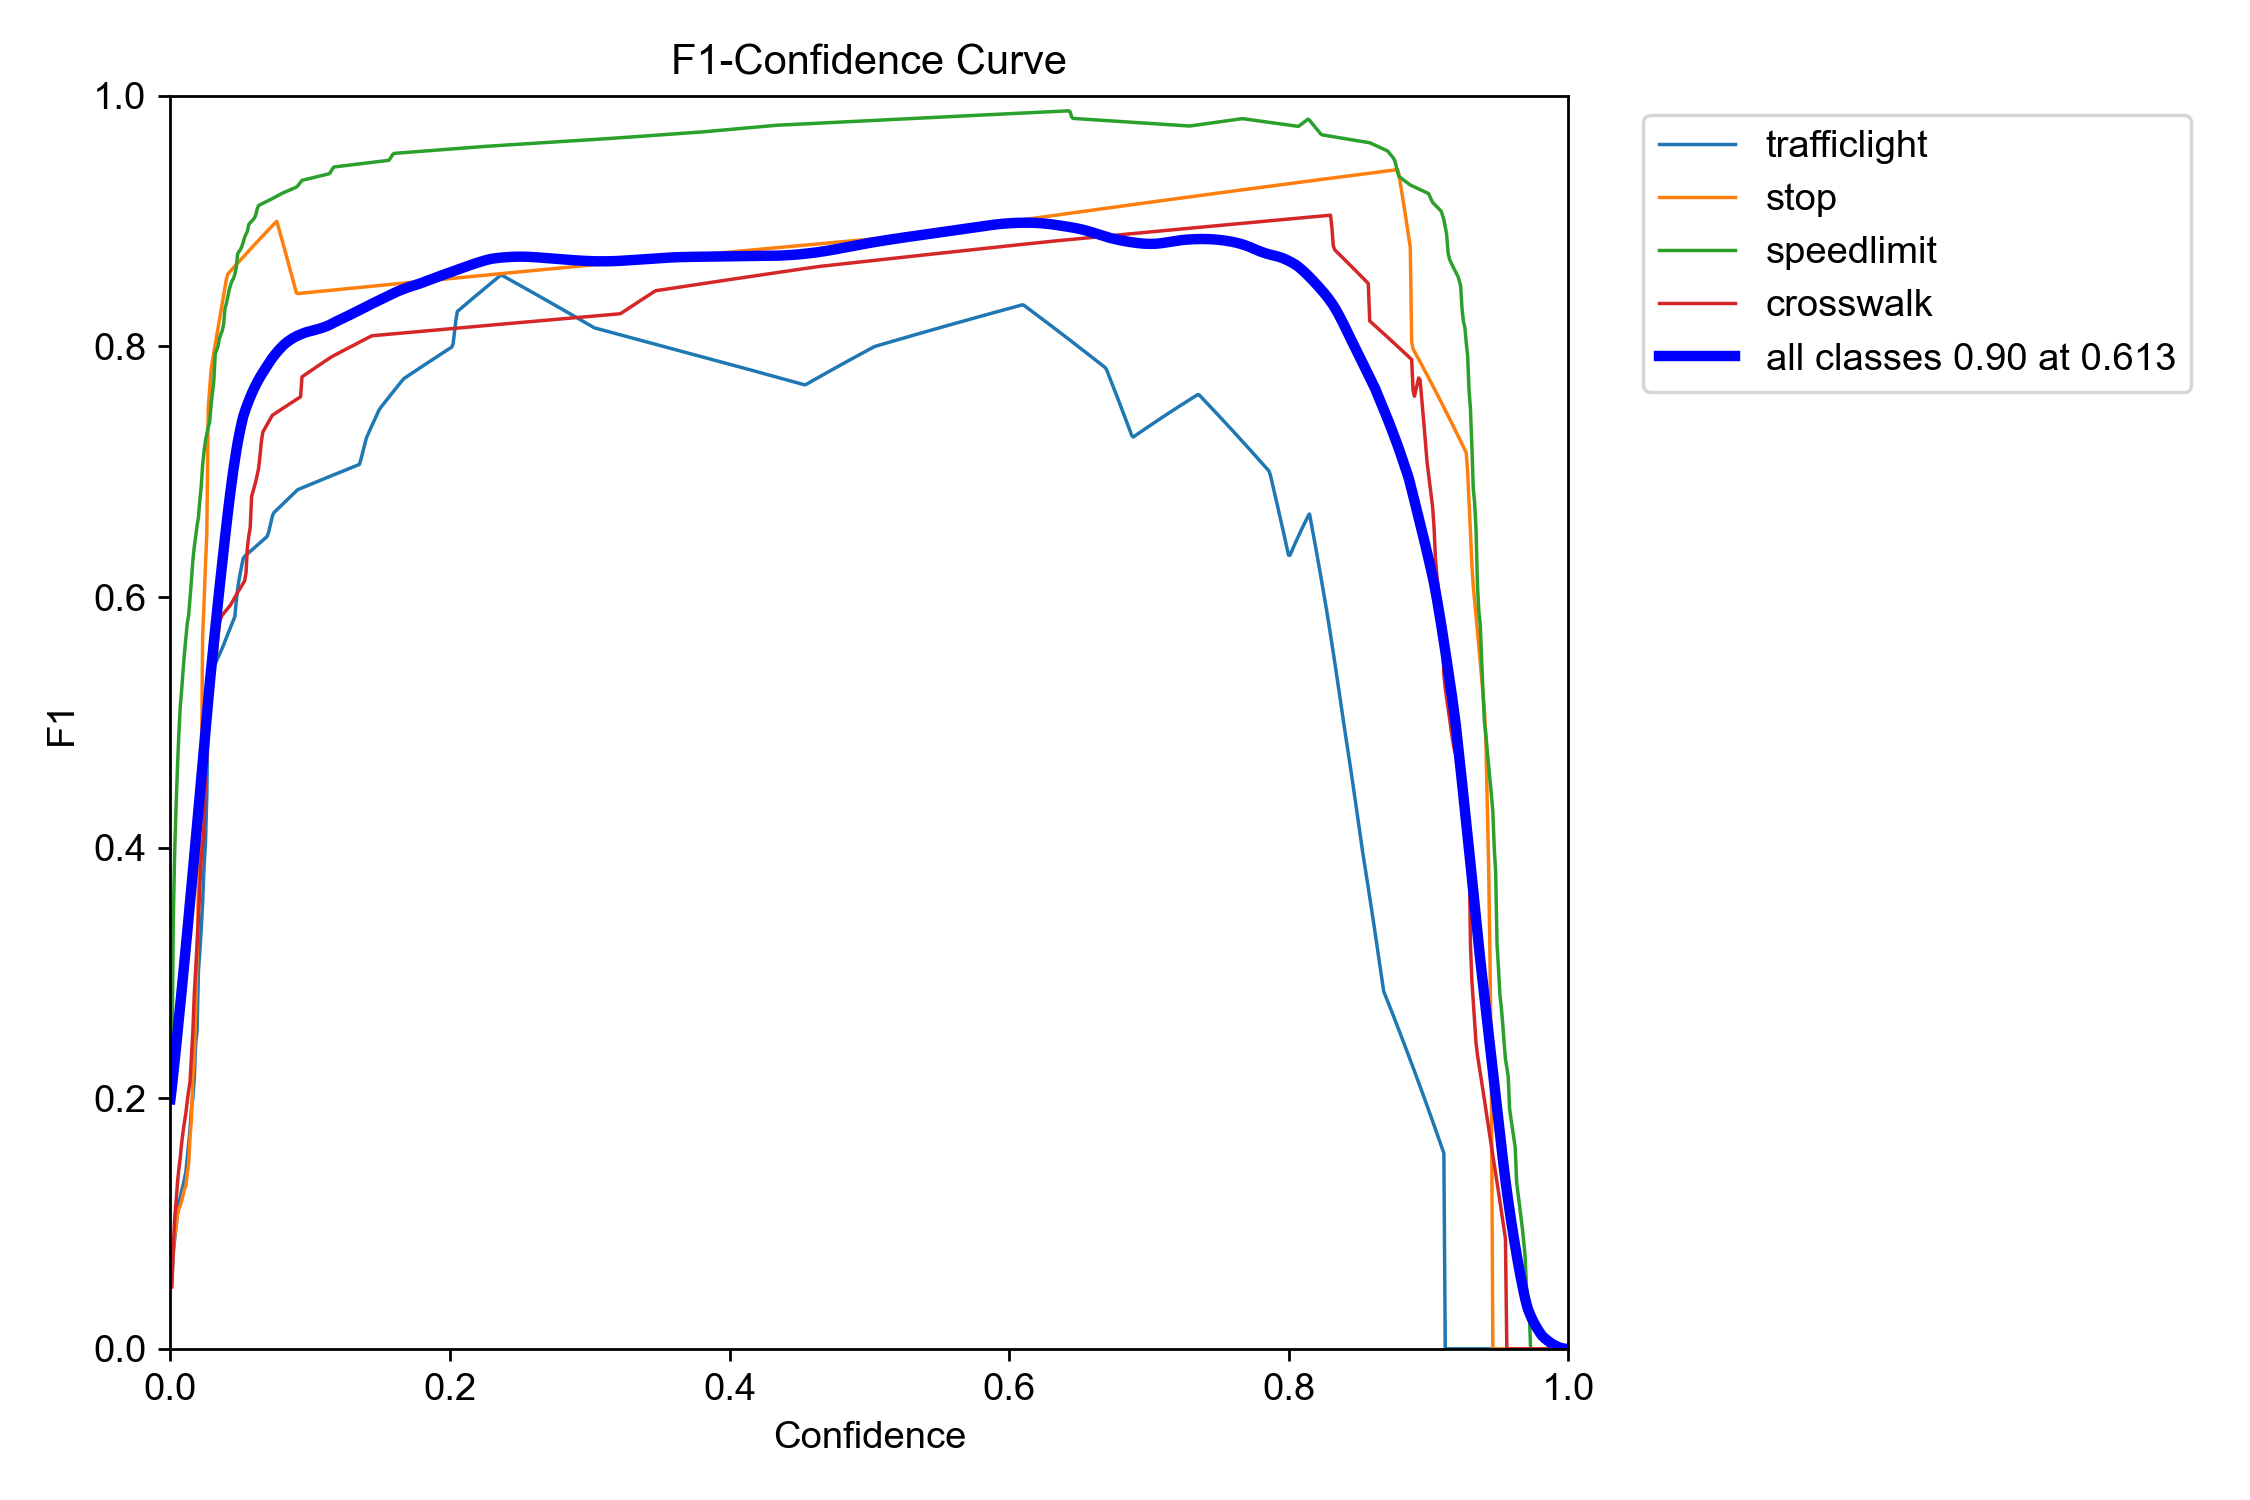

Metric: P_curve


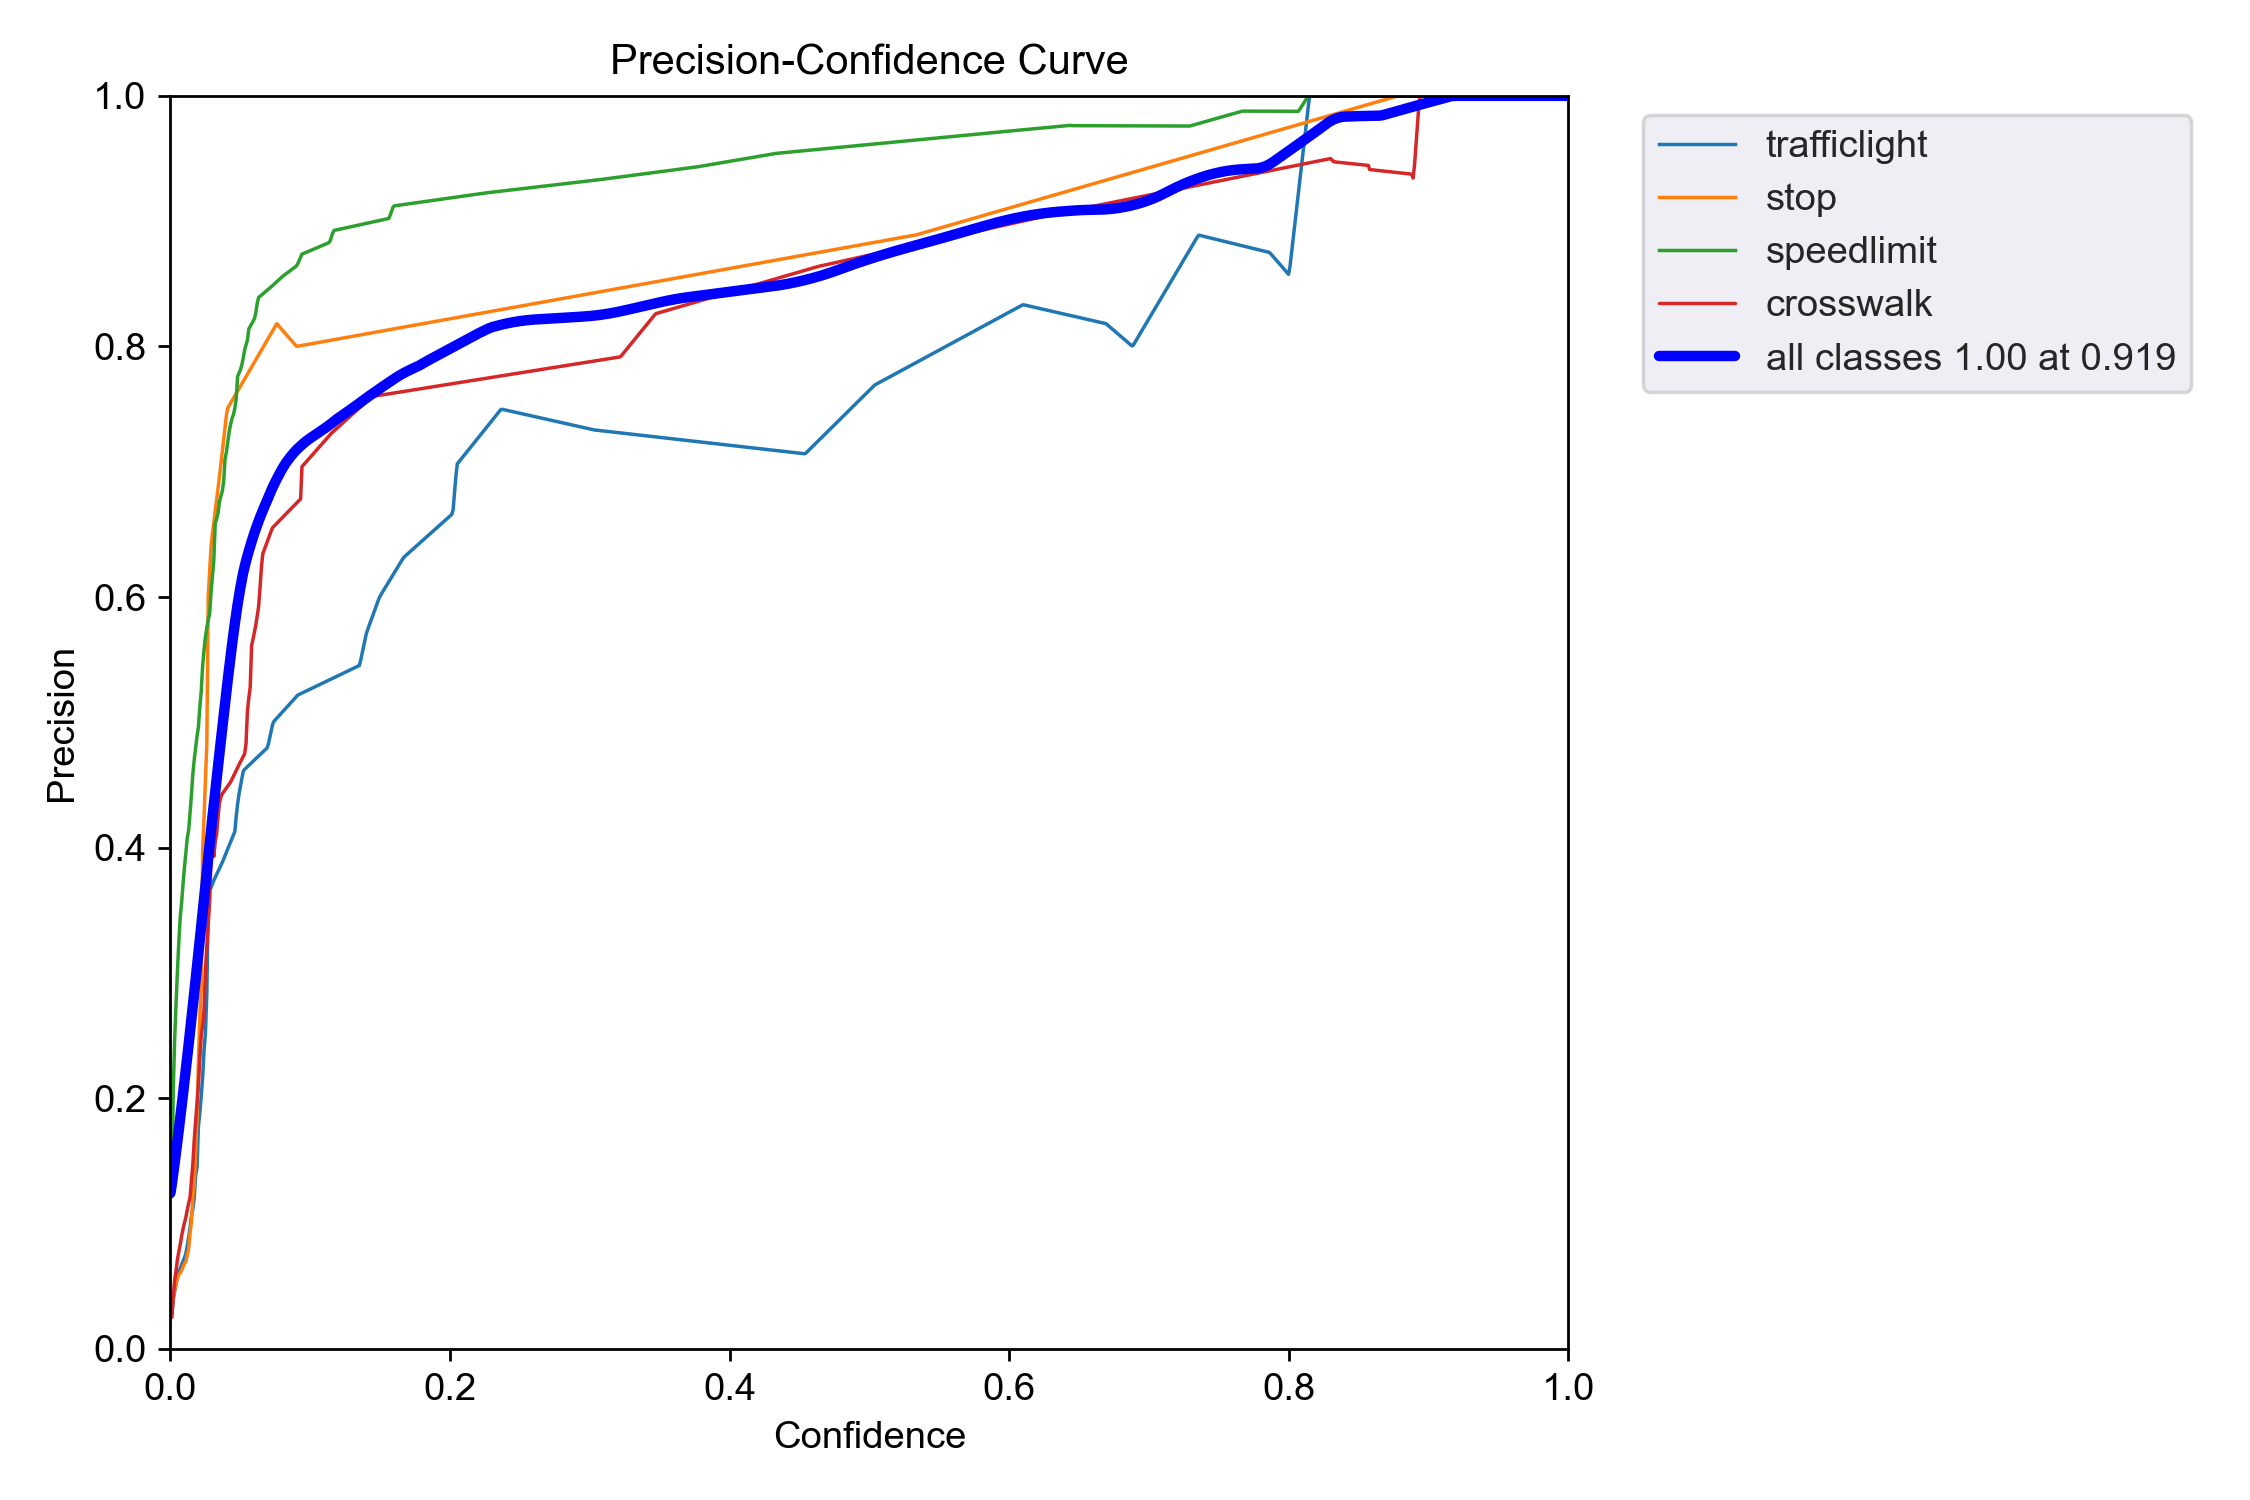

Metric: PR_curve


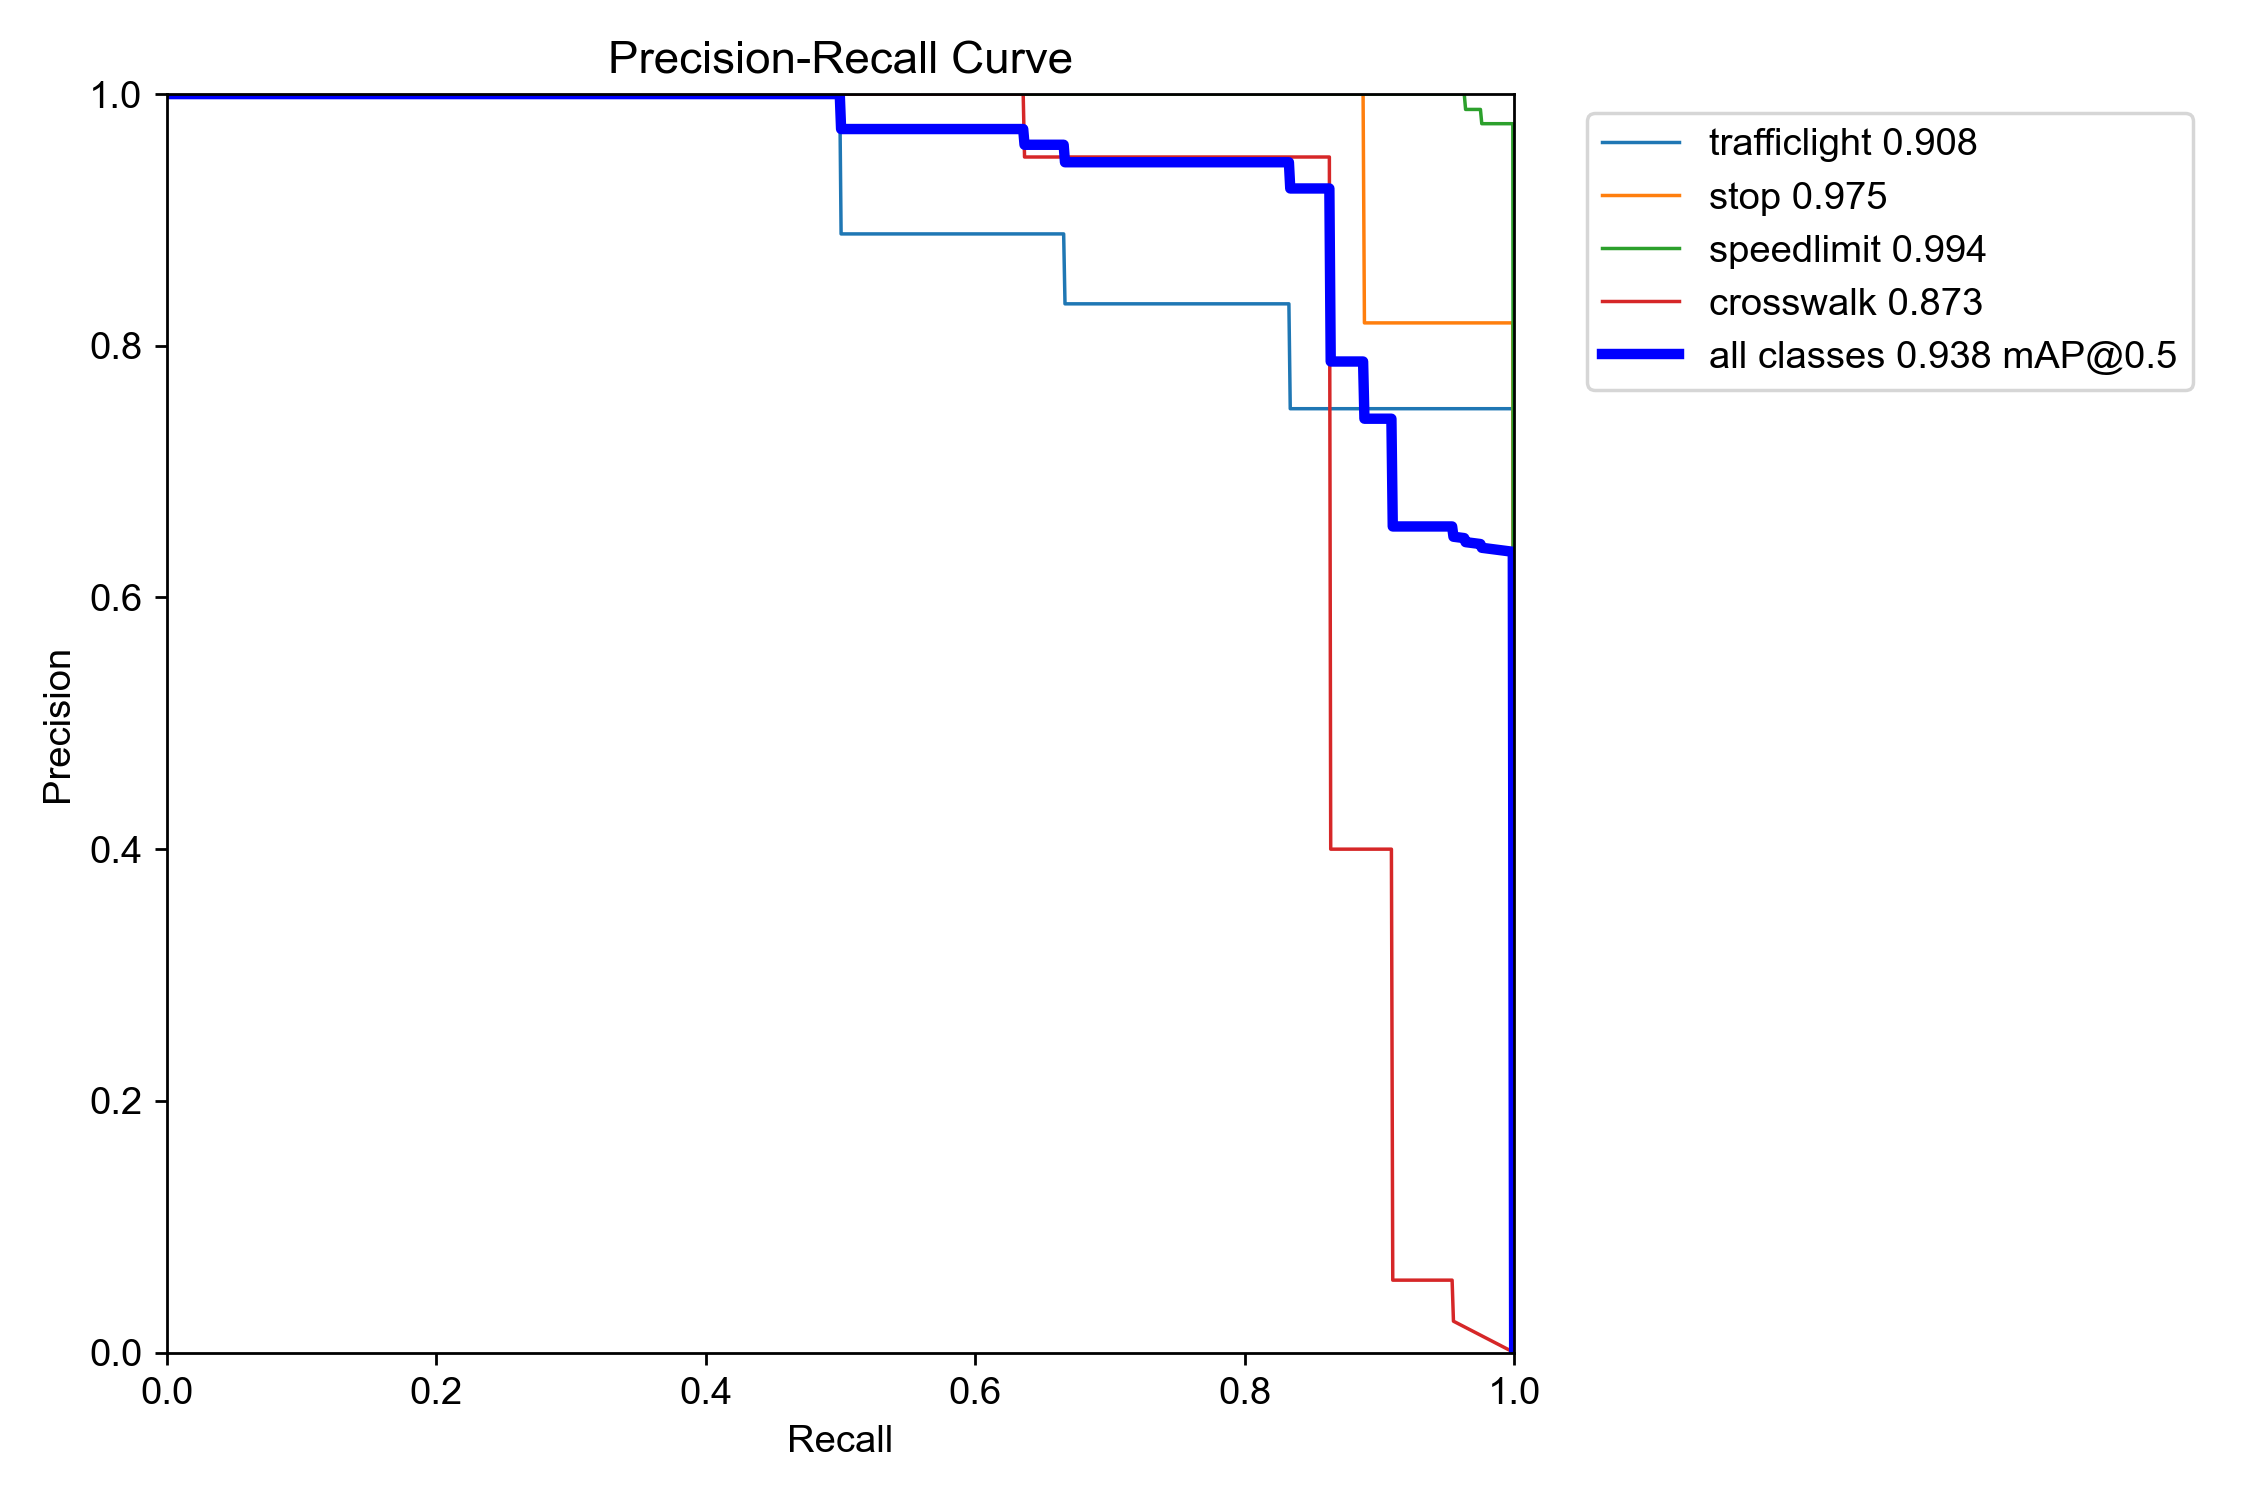

Metric: R_curve


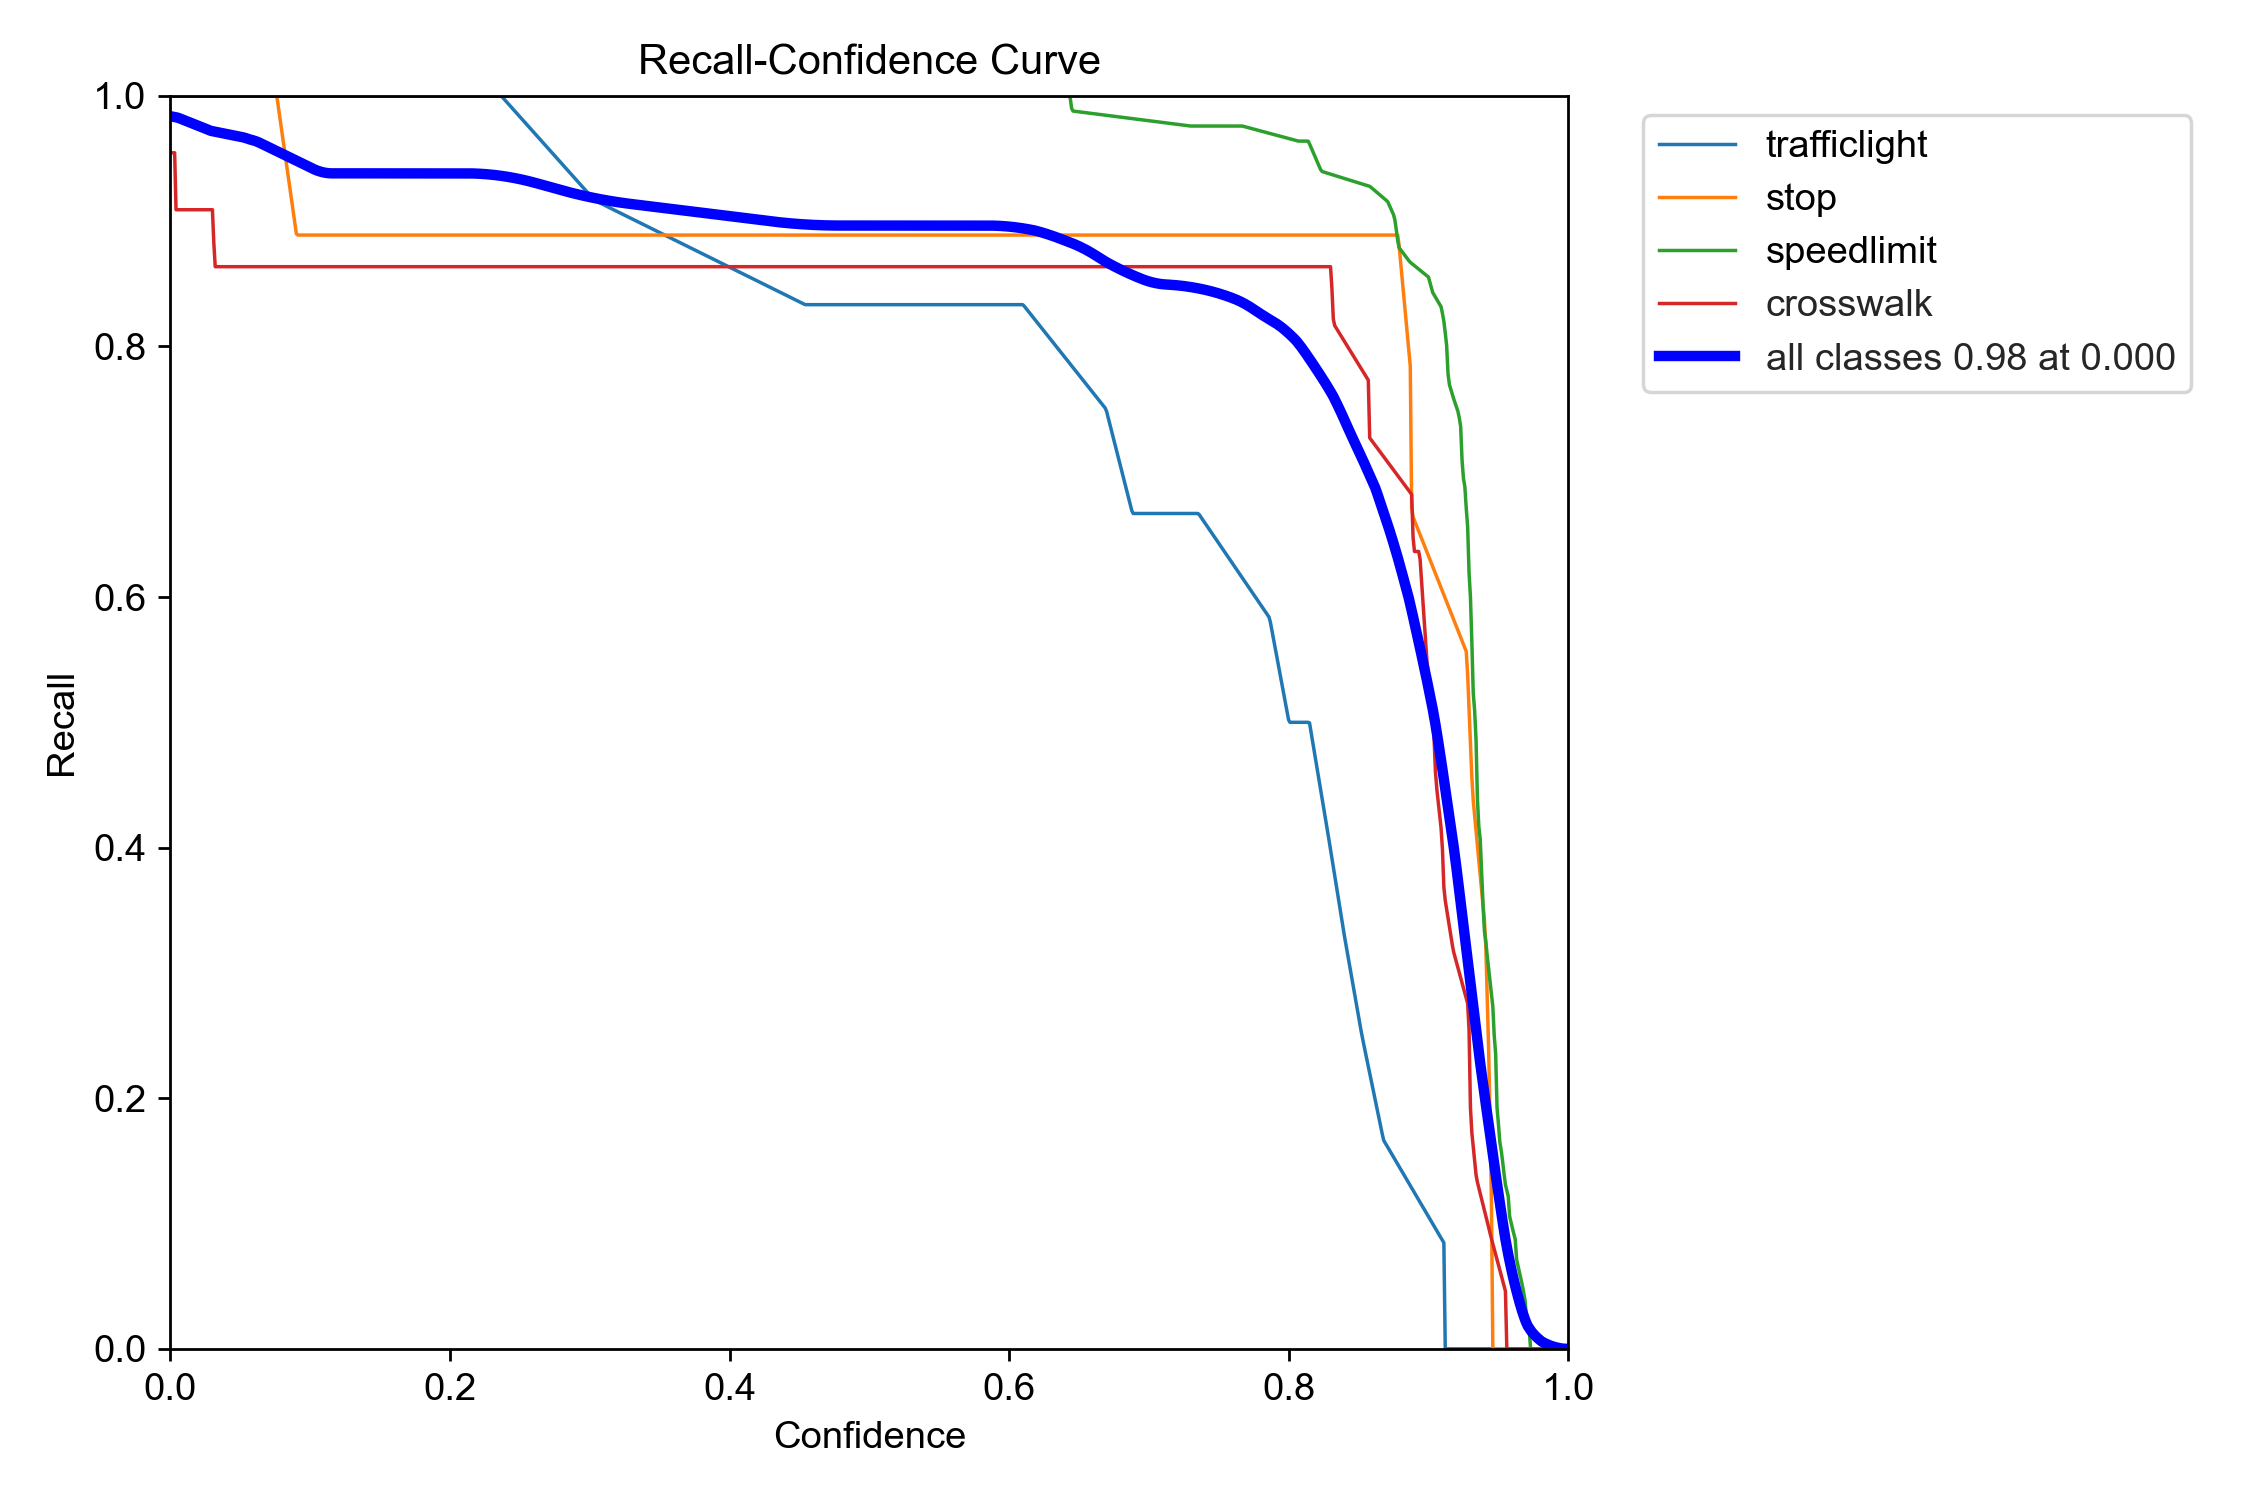

In [8]:
for metric in ['confusion_matrix', 'F1_curve', 'P_curve', 'PR_curve', 'R_curve']:
    print(f"Metric: {metric}")
    metric_path = f"./runs/train/exp/{metric}.png"
    display(Image(filename=metric_path))

The confusion matrix indicates how the model predicts for each class. The model performs well on predicting speed limit compared to the other class and sometimes confuses with the background. But overall it still predicts all class correctly.

The F1 confidence curve plots the F1 score against different confidence thresholds for every classes and all classes combined. The F1 score measures model’s accuracy that considers both precision and recall. A higher F1 score indicates better performance and the confidence threshold at which the F1 score is maximized is considered the optimal threshold for making predictions. It seems that on average, the model has an 90% precision at a confidence threshold of 0.613 for all classes.

The precision-confidence curve plots precision against different confidence thresholds for every classes and all classes combined. It displays how precision changes as we adjust the confidence level for classifying a prediction as positive. It seems that the model achieve 100% precision at a high confidence threshold of 0.919.

The precision-recall curve plots the trade-off between precision and recall for different threshold values. The model needs to balance between catching all true positives (recall) and ensuring what we catch is actually correct (precision). It seems that the model’s mean Average Precision is 93.8% across all classes at an Intersection over Union (IoU) threshold of 0.5

The recall-confidence curve plots recall against different confidence thresholds. It shows how recall changes as we adjust the confidence level. Recall decreases as the confidence threshold increases because a higher threshold may lead to fewer positive predictions, missing some actual positives. It seems that the model achieve 98% recall at the lowest confidence threshold, meaning the model captures most true positives but may also have many false positives.

Once the mode is trained, we can use the best checkpoint to evaluate the model on a test set.

From the documentation, the model can be validated against the test set to obtain the metrics. However, an issue arose when I try to execute the script, as it fails to output the expected metrics. So, I found a workaround by running the detection script to get the bounding boxes and confidence in txt file.

In [4]:
WEIGHTS = os.path.join(os.getcwd(), 'runs/train/exp/weights/best.pt')
SOURCE = 'D:/personal/self-learn/data-dataan/datasets/road-sign-detection-v2/split-data/test/images'

!python detect.py --weights {WEIGHTS} --source {SOURCE} --save-txt --save-conf

detect: weights=['D:\\personal\\self-learn\\data-dataan\\yolov5\\runs/train/exp/weights/best.pt'], source=D:/personal/self-learn/data-dataan/datasets/road-sign-detection-v2/split-data/test/images, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-312-g1bcd17ee Python-3.9.18 torch-2.2.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/89 D:\personal\self-learn\data-dataan\datasets\road-sign-detection-v2\split-data\test\images\road109.png: 448x640 1 speedlimit, 168.0ms
image 2/89 D:\personal\self-learn\data-dataan\datasets\road-sign-detection-v2\split-data\test\imag

Going through the actual validation script, I found that the underlying metric computation is based on [this repository](https://github.com/rafaelpadilla/Object-Detection-Metrics). So I use the same code and make a minor adjustment so I am able to calculate precision and recall for each class as well as for all classes.

In [1]:
import cv2

def convertToRelativeValues(size, box):
    dw = 1. / (size[0])
    dh = 1. / (size[1])
    cx = (box[1] + box[0]) / 2.0
    cy = (box[3] + box[2]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = cx * dw
    y = cy * dh
    w = w * dw
    h = h * dh
    return (x, y, w, h)

def convertToAbsoluteValues(size, box):
    xIn = round(((2 * float(box[0]) - float(box[2])) * size[0] / 2))
    yIn = round(((2 * float(box[1]) - float(box[3])) * size[1] / 2))
    xEnd = xIn + round(float(box[2]) * size[0])
    yEnd = yIn + round(float(box[3]) * size[1])
    if xIn < 0:
        xIn = 0
    if yIn < 0:
        yIn = 0
    if xEnd >= size[0]:
        xEnd = size[0] - 1
    if yEnd >= size[1]:
        yEnd = size[1] - 1
    return (xIn, yIn, xEnd, yEnd)

def add_bb_into_image(image, bb, color=(255, 0, 0), thickness=2, label=None):
    r = int(color[0])
    g = int(color[1])
    b = int(color[2])

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    fontThickness = 1

    x1, y1, x2, y2 = bb.getAbsoluteBoundingBox('xyx2y2')
    x1 = int(x1)
    y1 = int(y1)
    x2 = int(x2)
    y2 = int(y2)
    cv2.rectangle(image, (x1, y1), (x2, y2), (b, g, r), thickness)
    if label is not None:
        (tw, th) = cv2.getTextSize(label, font, fontScale, fontThickness)[0]
        (xin_bb, yin_bb) = (x1 + thickness, y1 - th + int(12.5 * fontScale))
        if yin_bb - th <= 0:
            yin_bb = y1 + th
        r_Xin = x1 - int(thickness / 2)
        r_Yin = y1 - th - int(thickness / 2)
        cv2.rectangle(image, (r_Xin, r_Yin - thickness), 
                      (r_Xin + tw + thickness * 3, r_Yin + th + int(12.5 * fontScale)), (b, g, r), -1)
        cv2.putText(image, label, (xin_bb, yin_bb), font, fontScale, (0, 0, 0), fontThickness, cv2.LINE_AA)
    return image

In [2]:
class BoundingBox:
    def __init__(self, imageName, classId, x, y, w, h, typeCoordinates='absolute', imgSize = None, 
                 bbType='GroundTruth', classConfidence=None, format='xywh'):
        self._imageName = imageName
        self._typeCoordinates = typeCoordinates
        if typeCoordinates == 'relative' and imgSize is None:
            raise Exception('Parameter \'imgSize\' is required. It is necessary to inform the image size.')
        if bbType == 'detected' and classConfidence is None:
            raise Exception('For bbType=\'Detection\', it is necessary to inform the classConfidence value.')
        
        self._classConfidence = classConfidence
        self._bbType = bbType
        self._classId = classId
        self._format = format
        
        if (typeCoordinates == 'relative'):
            (self._x, self._y, self._w, self._h) = convertToAbsoluteValues(imgSize, (x, y, w, h))
            self._width_img = imgSize[0]
            self._height_img = imgSize[1]
            if format == 'xywh':
                self._x2 = self._w
                self._y2 = self._h
                self._w = self._x2 - self._x
                self._h = self._y2 - self._y
            else:
                raise Exception('For relative coordinates, the format must be XYWH')
            
        else:
            self._x = x
            self._y = y
            if format == 'xywh':
                self._w = w
                self._h = h
                self._x2 = self._x + self._w
                self._y2 = self._y + self._h
            else:
                self._x2 = w
                self._y2 = h
                self._w = self._x2 - self._x
                self._h = self._y2 - self._y
        if imgSize is None:
            self._width_img = None
            self._height_img = None
        else:
            self._width_img = imgSize[0]
            self._height_img = imgSize[1]

    def getAbsoluteBoundingBox(self, format='xywh'):
        if format == 'xywh':
            return (self._x, self._y, self._w, self._h)
        elif format == 'xyx2y2':
            return (self._x, self._y, self._x2, self._y2)

    def getRelativeBoundingBox(self, imgSize=None):
        if imgSize is None and self._width_img is None and self._height_img is None:
            raise Exception('Parameter \'imgSize\' is required. It is necessary to inform the image size.')
        if imgSize is not None:
            return convertToRelativeValues((imgSize[0], imgSize[1]), (self._x, self._x2, self._y, self._y2))
        else:
            return convertToRelativeValues((self._width_img, self._height_img), (self._x, self._x2, self._y, self._y2))

    def getImageName(self):
        return self._imageName

    def getConfidence(self):
        return self._classConfidence

    def getFormat(self):
        return self._format

    def getClassId(self):
        return self._classId

    def getImageSize(self):
        return (self._width_img, self._height_img)

    def getCoordinatesType(self):
        return self._typeCoordinates

    def getBBType(self):
        return self._bbType

    @staticmethod
    def compare(det1, det2):
        det1BB = det1.getAbsoluteBoundingBox()
        det1ImgSize = det1.getImageSize()
        det2BB = det2.getAbsoluteBoundingBox()
        det2ImgSize = det2.getImageSize()

        if det1.getClassId() == det2.getClassId() and det1.classConfidence() == det2.classConfidence() and \
        det1BB[0] == det2BB[0] and det1BB[1] == det2BB[1] and det1BB[2] == det2BB[2] and det1BB[3] == det2BB[3] and \
        det1ImgSize[0] == det2ImgSize[0] and det1ImgSize[1] == det2ImgSize[1]:
            return True
        return False

    @staticmethod
    def clone(boundingBox):
        absBB = boundingBox.getAbsoluteBoundingBox(format='xywh')
        newBoundingBox = BoundingBox(boundingBox.getImageName(), boundingBox.getClassId(), absBB[0], absBB[1], 
                                     absBB[2], absBB[3], typeCoordinates=boundingBox.getCoordinatesType(), 
                                     imgSize=boundingBox.getImageSize(), bbType=boundingBox.getBBType(), 
                                     classConfidence=boundingBox.getConfidence(), format='xywh')
        return newBoundingBox

In [3]:
class BoundingBoxes:
    def __init__(self):
        self._boundingBoxes = []

    def addBoundingBox(self, bb):
        self._boundingBoxes.append(bb)

    def removeBoundingBox(self, _boundingBox):
        for d in self._boundingBoxes:
            if BoundingBox.compare(d, _boundingBox):
                del self._boundingBoxes[d]
                return

    def removeAllBoundingBoxes(self):
        self._boundingBoxes = []

    def getBoundingBoxes(self):
        return self._boundingBoxes

    def getBoundingBoxByClass(self, classId):
        boundingBoxes = []
        for d in self._boundingBoxes:
            if d.getClassId() == classId:
                boundingBoxes.append(d)
        return boundingBoxes

    def getClasses(self):
        classes = []
        for d in self._boundingBoxes:
            c = d.getClassId()
            if c not in classes:
                classes.append(c)
        return classes

    def getBoundingBoxesByType(self, bbType):
        return [d for d in self._boundingBoxes if d.getBBType() == bbType]

    def getBoundingBoxesByImageName(self, imageName):
        return [d for d in self._boundingBoxes if d.getImageName() == imageName]

    def count(self, bbType=None):
        if bbType is None:
            return len(self._boundingBoxes)
        count = 0
        for d in self._boundingBoxes:
            if d.getBBType() == bbType:
                count += 1
        return count

    def clone(self):
        newBoundingBoxes = BoundingBoxes()
        for d in self._boundingBoxes:
            det = BoundingBox.clone(d)
            newBoundingBoxes.addBoundingBox(det)
        return newBoundingBoxes

    def drawAllBoundingBoxes(self, image, imageName):
        bbxes = self.getBoundingBoxesByImageName(imageName)
        for bb in bbxes:
            if bb.getBBType() == 'GroundTruth':
                image = add_bb_into_image(image, bb, color=(0, 255, 0))
            else:
                image = add_bb_into_image(image, bb, color=(255, 0, 0))
        return image

In [13]:
import glob
import os

def getBoundingBoxes(directory, isGT, bbFormat, coordType, allBoundingBoxes=None, allClasses=None, imgSize=(0, 0)):
    if allBoundingBoxes is None:
        allBoundingBoxes = BoundingBoxes()
    if allClasses is None:
        allClasses = []
    
    os.chdir(directory)
    files = glob.glob('*.txt')
    files.sort()
    
    for f in files:
        nameOfImage = f.replace('.txt', '')
        fh1 = open(f, 'r')
        for line in fh1:
            line = line.replace('\n', '')
            if line.replace(' ', '') == '':
                continue
            splitLine = line.split(' ')
            if isGT:
                idClass = (splitLine[0])
                x = float(splitLine[1])
                y = float(splitLine[2])
                w = float(splitLine[3])
                h = float(splitLine[4])
                bb = BoundingBox(nameOfImage, idClass, x, y, w, h, coordType, imgSize, 'GroundTruth', format=bbFormat)
            else:
                idClass = (splitLine[0])
                x = float(splitLine[1])
                y = float(splitLine[2])
                w = float(splitLine[3])
                h = float(splitLine[4])
                confidence = float(splitLine[5])
                bb = BoundingBox(nameOfImage, idClass, x, y, w, h, coordType, imgSize, 'detected', confidence, format=bbFormat)
            allBoundingBoxes.addBoundingBox(bb)
            if idClass not in allClasses:
                allClasses.append(idClass)
        fh1.close()
    return allBoundingBoxes, allClasses

Here we set the path to the txt data and also specify the format, coordinate type, and image size.

In [56]:
base_path = 'D:/personal/self-learn/data-dataan/'
gtFolder = os.path.join(base_path, 'datasets/road-sign-detection-v2/split-data/test/labels-v2')
gtFormat = 'xywh'
gtCoordType = 'relative'
imgSize = (640, 640)

allBoundingBoxes, allClasses = getBoundingBoxes(gtFolder, True, gtFormat, gtCoordType, imgSize=imgSize)

detFolder = os.path.join(base_path, 'yolov5/runs/detect/exp/labels')
detFormat = 'xywh'
detCoordType = 'relative'
imgSize = (640, 640)

allBoundingBoxes, allClasses = getBoundingBoxes(detFolder, False, detFormat, detCoordType, allBoundingBoxes, 
                                                allClasses, imgSize=imgSize)

allClasses.sort()

In [57]:
import numpy as np
import sys
import matplotlib.pyplot as plt

class Evaluator:
    def GetMetrics(self, boundingboxes, IOUThreshold=0.5, method='EveryPointInterpolation'):
        ret = []
        groundTruths = []
        detections = []
        classes = []
        
        for bb in boundingboxes.getBoundingBoxes():
            if bb.getBBType() == 'GroundTruth':
                groundTruths.append([bb.getImageName(), bb.getClassId(), 1, bb.getAbsoluteBoundingBox('xyx2y2')])
            else:
                detections.append([bb.getImageName(), bb.getClassId(), bb.getConfidence(), bb.getAbsoluteBoundingBox('xyx2y2')])
            if bb.getClassId() not in classes:
                classes.append(bb.getClassId())
        classes = sorted(classes)
        
        for c in classes:
            dects = []
            [dects.append(d) for d in detections if d[1] == c]
            gts = {}
            npos = 0
            for g in groundTruths:
                if g[1] == c:
                    npos += 1
                    gts[g[0]] = gts.get(g[0], []) + [g]
            
            dects = sorted(dects, key=lambda conf: conf[2], reverse=True)
            TP = np.zeros(len(dects))
            FP = np.zeros(len(dects))
            det = {key: np.zeros(len(gts[key])) for key in gts}

            for d in range(len(dects)):
                gt = gts[dects[d][0]] if dects[d][0] in gts else []
                iouMax = sys.float_info.min
                for j in range(len(gt)):
                    iou = Evaluator.iou(dects[d][3], gt[j][3])
                    if iou > iouMax:
                        iouMax = iou
                        jmax = j
                if iouMax >= IOUThreshold:
                    if det[dects[d][0]][jmax] == 0:
                        TP[d] = 1
                        det[dects[d][0]][jmax] = 1
                    else:
                        FP[d] = 1
                else:
                    FP[d] = 1
            
            acc_FP = np.cumsum(FP)
            acc_TP = np.cumsum(TP)
            rec = acc_TP / npos
            prec = np.divide(acc_TP, (acc_FP + acc_TP))
            if method == 'EveryPointInterpolation':
                [ap, mpre, mrec, ii] = Evaluator.CalculateAveragePrecision(rec, prec)
            else:
                [ap, mpre, mrec, _] = Evaluator.ElevenPointInterpolatedAP(rec, prec)
            r = {
                'class': c,
                'precision': prec,
                'recall': rec,
                'AP': ap,
                'interpolated precision': mpre,
                'interpolated recall': mrec,
                'total positives': npos,
                'total TP': np.sum(TP),
                'total FP': np.sum(FP)
            }
            ret.append(r)
        return ret

    def PlotPrecisionRecallCurve(self, boundingBoxes, IOUThreshold=0.5, method='EveryPointInterpolation', 
                                 showAP=False, showInterpolatedPrecision=False, savePath=None, showGraphic=True):
        results = self.GetMetrics(boundingBoxes, IOUThreshold, method)
        result = None

        for result in results:
            if result is None:
                raise Exception('Error: Class %d could not be found.' % classId)
            classId = result['class']
            precision = result['precision']
            recall = result['recall']
            average_precision = result['AP']
            mpre = result['interpolated precision']
            mrec = result['interpolated recall']
            npos = result['total positives']
            total_tp = result['total TP']
            total_fp = result['total FP']

            plt.close()
            if showInterpolatedPrecision:
                if method == 'EveryPointInterpolation':
                    plt.plot(mrec, mpre, '--r', label='Interpolated precision (every point)')
                elif method == 'ElevenPointInterpolation':
                    nrec = []
                    nprec = []
                    for idx in range(len(mrec)):
                        r = mrec[idx]
                        if r not in nrec:
                            idxEq = np.argwhere(mrec == r)
                            nrec.append(r)
                            nprec.append(max([mpre[int(id)] for id in idxEq]))
                    plt.plot(nrec, nprec, 'or', label='11-point interpolated precision')
            plt.plot(recall, precision, label='Precision')
            plt.xlabel('recall')
            plt.ylabel('precision')
            if showAP:
                ap_str = "{0:.2f}%".format(average_precision * 100)
                plt.title('Precision x Recall curve \nClass: %s, AP: %s' % (str(classId), ap_str))
            else:
                plt.title('Precision x Recall curve \nClass: %s' % str(classId))
            plt.legend(shadow=True)
            plt.grid()
            if savePath is not None:
                plt.savefig(os.path.join(savePath, str(classId) + '.png'))
            if showGraphic is True:
                plt.show()
                plt.pause(0.05)
        return results
        
    @staticmethod
    def CalculateAveragePrecision(rec, prec):
        mrec = []
        mrec.append(0)
        [mrec.append(e) for e in rec]
        mrec.append(1)

        mpre = []
        mpre.append(0)
        [mpre.append(e) for e in prec]
        mpre.append(0)

        for i in range(len(mpre) - 1, 0, -1):
            mpre[i - 1] = max(mpre[i - 1], mpre[i])
        ii = []
        for i in range(len(mrec) - 1):
            if mrec[1 + i] != mrec[i]:
                ii.append(i + 1)
        ap = 0
        for i in ii:
            ap = ap + np.sum(mrec[i] - mrec[i - 1]) * mpre[i]
        return [ap, mpre[0:len(mpre) - 1], mrec[0:len(mpre) - 1], ii]

    @staticmethod
    def ElevenPointInterpolatedAP(rec, prec):
        mrec = []
        [mrec.append(e) for e in rec]
        mpre = []
        [mpre.append(e) for e in prec]
        recallValues = np.linspace(0, 1, 11)
        recallValues = list(recallValues[::-1])
        rhoInterp = []
        recallValid = []

        for r in recallValues:
            argGreaterRecalls = np.argwhere(mrec[:] >= r)
            pmax = 0
            if argGreaterRecalls.size != 0:
                pmax = max(mpre[argGreaterRecalls.min():])
            recallValid.append(r)
            rhoInterp.append(pmax)

        ap = sum(rhoInterp) / 11
        rvals.append(recallValid[0])
        [rvals.append(e) for e in recallValid]
        rvals.append(0)
        pvals = []
        pvals.append(0)
        [pvals.append(e) for e in rhoInterp]
        pvals.append(0)
        cc = []
        for i in range(len(rvals)):
            p = (rvals[i], pvals[i - 1])
            if p not in cc:
                cc.append(p)
            p = (rvals[i], pvals[i])
            if p not in cc:
                cc.append(p)
        recallValues = [i[0] for i in cc]
        rhoInterp = [i[1] for i in cc]
        return [ap, rhoInterp, recallValues, None]

    @staticmethod
    def _getAllIOUs(reference, detections):
        ret = []
        bbReference = reference.getAbsoluteBoundingBox('xyx2y2')
        for d in detections:
            bb = d.getAbsoluteBoundingBox('xyx2y2')
            iou = Evaluator.iou(bbReference, bb)
            ret.append((iou, reference, d))
        return sorted(ret, key=lambda i: i[0], reverse=True)

    @staticmethod
    def iou(boxA, boxB):
        if Evaluator._boxesIntersect(boxA, boxB) is False:
            return 0
        interArea = Evaluator._getIntersectionArea(boxA, boxB)
        union = Evaluator._getUnionAreas(boxA, boxB, interArea=interArea)
        iou = interArea / union
        assert iou >= 0
        return iou

    @staticmethod
    def _boxesIntersect(boxA, boxB):
        if boxA[0] > boxB[2]:
            return False
        if boxB[0] > boxA[2]:
            return False
        if boxA[3] < boxB[1]:
            return False
        if boxA[1] > boxB[3]:
            return False
        return True

    @staticmethod
    def _getIntersectionArea(boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        return (xB - xA + 1) * (yB - yA + 1)

    @staticmethod
    def _getUnionAreas(boxA, boxB, interArea=None):
        area_A = Evaluator._getArea(boxA)
        area_B = Evaluator._getArea(boxB)
        if interArea is None:
            interArea = Evaluator._getIntersectionArea(boxA, boxB)
        return float(area_A + area_B - interArea)

    @staticmethod
    def _getArea(box):
        return (box[2] - box[0] + 1) * (box[3] - box[1] + 1)

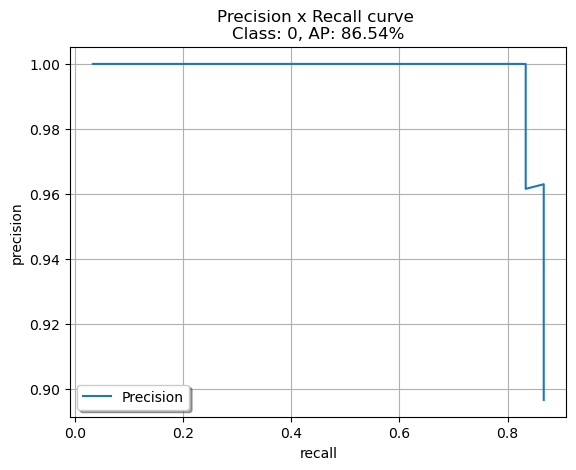

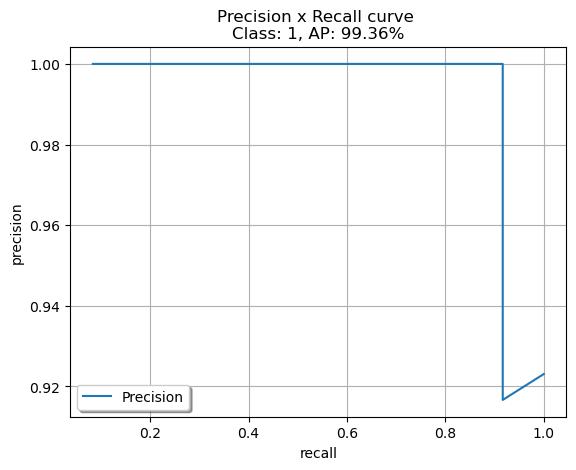

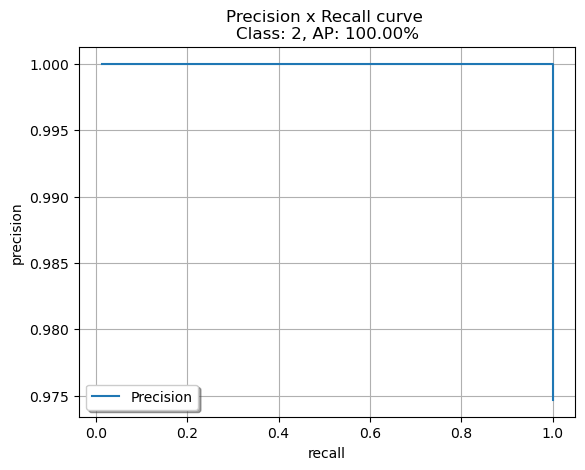

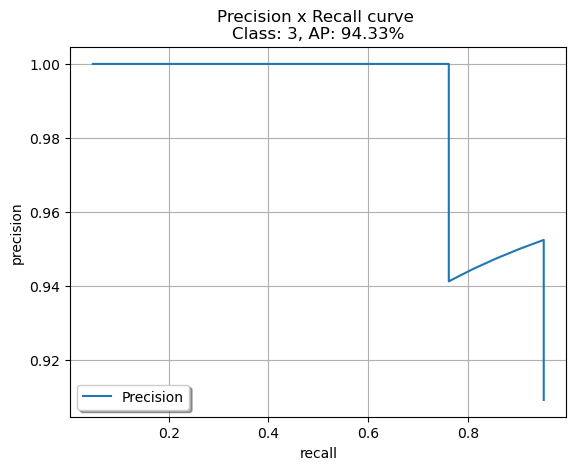

Average Precision (AP), Precision and Recall per class:
Class: 0
AP: 86.54% (0)
Precision: 0.8966
Recall: 0.8667 

Class: 1
AP: 99.36% (1)
Precision: 0.9231
Recall: 1.0000 

Class: 2
AP: 100.00% (2)
Precision: 0.9747
Recall: 1.0000 

Class: 3
AP: 94.33% (3)
Precision: 0.9091
Recall: 0.9524 

Overall metrics:
mAP: 95.06%
Precision: 92.59%
Recall: 95.48%


In [58]:
# boundingboxes = getBoundingBoxes()
evaluator = Evaluator()
acc_AP = 0
validClasses = 0
iouThreshold = 0.3
# savePath = os.path.join(base_path, 'models/road-sign-detection-v2/yolov5')
showPlot = True

detections = evaluator.PlotPrecisionRecallCurve(allBoundingBoxes, IOUThreshold=iouThreshold, method='EveryPointInterpolation', 
                                   showAP=True, showInterpolatedPrecision=False, showGraphic=showPlot)

all_precision = []
all_recall = []

print(f"Average Precision (AP), Precision and Recall per class:")
for metricsPerClass in detections:
    cl = metricsPerClass['class']
    ap = metricsPerClass['AP']
    precision = metricsPerClass['precision']
    recall = metricsPerClass['recall']
    totalPositives = metricsPerClass['total positives']
    total_TP = metricsPerClass['total TP']
    total_FP = metricsPerClass['total FP']
    if totalPositives > 0:
        validClasses = validClasses + 1
        acc_AP = acc_AP + ap
        prec = ['%.2f' % p for p in precision]
        rec = ['%.2f' % r for r in recall]
        ap_str = "{0:.2f}%".format(ap * 100)
        print(f"Class: {cl}")
        print(f"AP: {ap_str} ({cl})")
        compute_precision = total_TP / (total_TP + total_FP)
        print(f"Precision: {compute_precision:.4f}")
        compute_recall = total_TP / totalPositives
        print(f"Recall: {compute_recall:.4f} \n")
        all_precision.append(compute_precision)
        all_recall.append(compute_recall)

print(f"Overall metrics:")
mAP = acc_AP / validClasses
mAP_str = "{0:.2f}%".format(mAP * 100)
print(f"mAP: {mAP_str}")

final_precision = np.mean(all_precision)
print(f"Precision: {(final_precision * 100):.2f}%")

final_recall = np.mean(all_recall)
print(f"Recall: {(final_recall * 100):.2f}%")

The results suggest that the model is performing very well across all classes. This is aligns with the prior training result even though the data being fed is different. 

Next, perform inference tests on the same images used in the previous notebook.

In [75]:
WEIGHTS = os.path.join(os.getcwd(), 'runs/train/exp/weights/best.pt')
SOURCE = 'D:/personal/self-learn/data-dataan/datasets/road-sign-detection-v2/inference'

!python detect.py --weights {WEIGHTS} --source {SOURCE}

detect: weights=['D:\\personal\\self-learn\\data-dataan\\yolov5\\runs/train/exp/weights/best.pt'], source=D:/personal/self-learn/data-dataan/datasets/road-sign-detection-v2/inference, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-312-g1bcd17ee Python-3.9.18 torch-2.2.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/6 D:\personal\self-learn\data-dataan\datasets\road-sign-detection-v2\inference\img_1.jpg: 640x480 1 trafficlight, 168.9ms
image 2/6 D:\personal\self-learn\data-dataan\datasets\road-sign-detection-v2\inference\img_2.jpg: 640x480 1 stop, 152.5ms
i

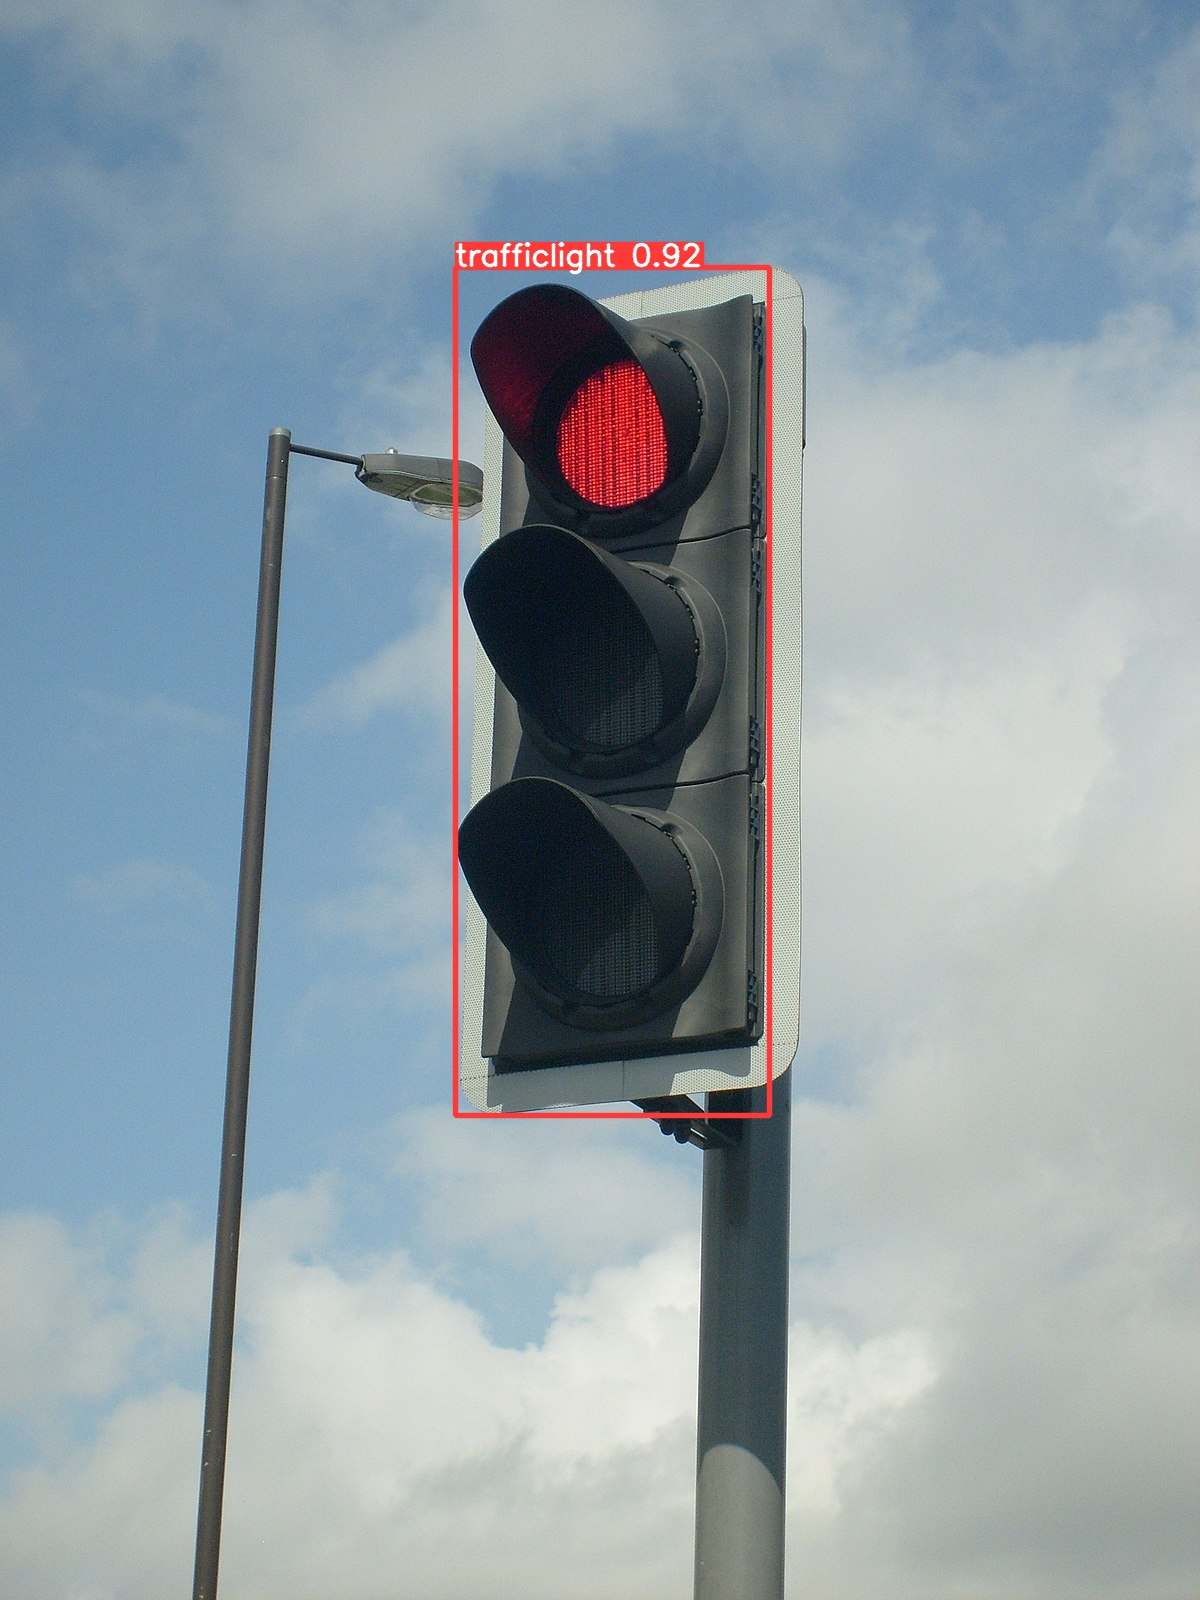

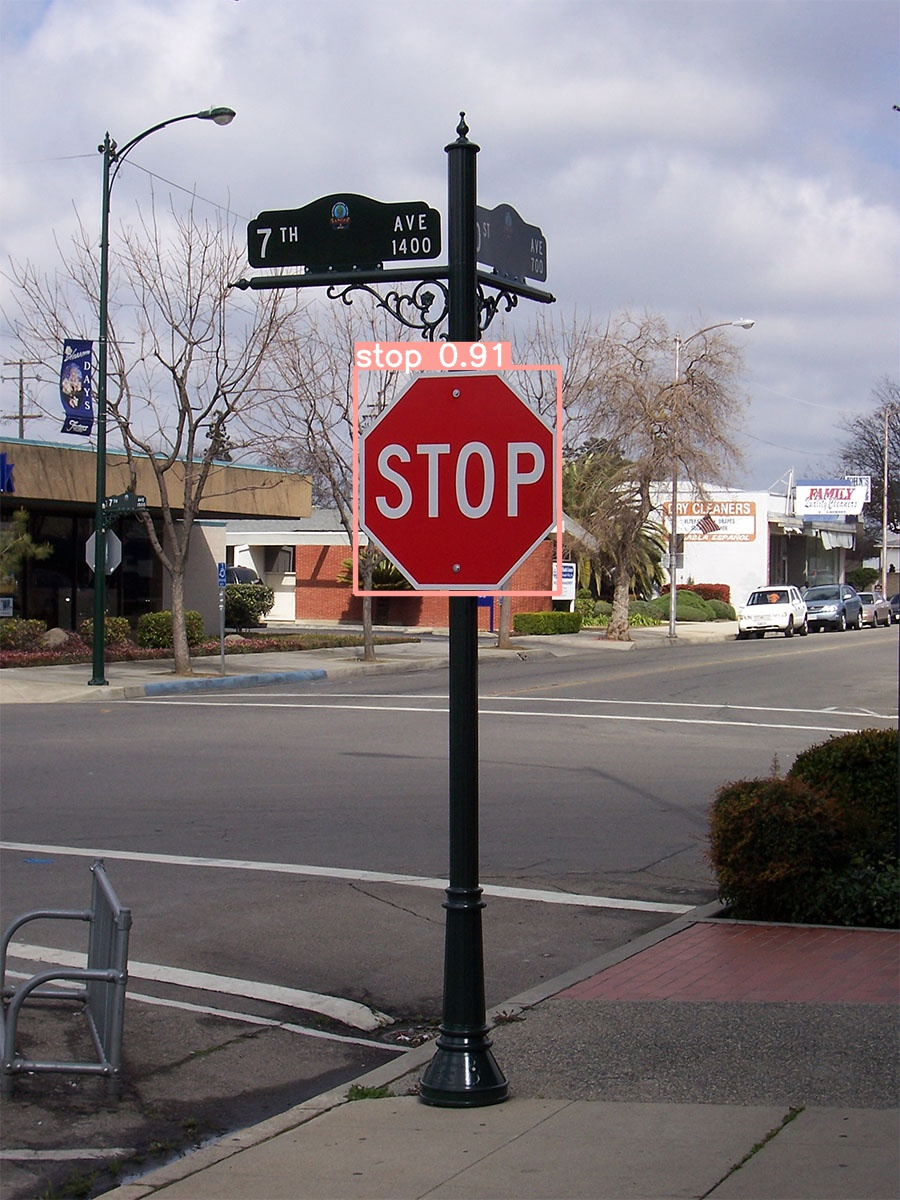

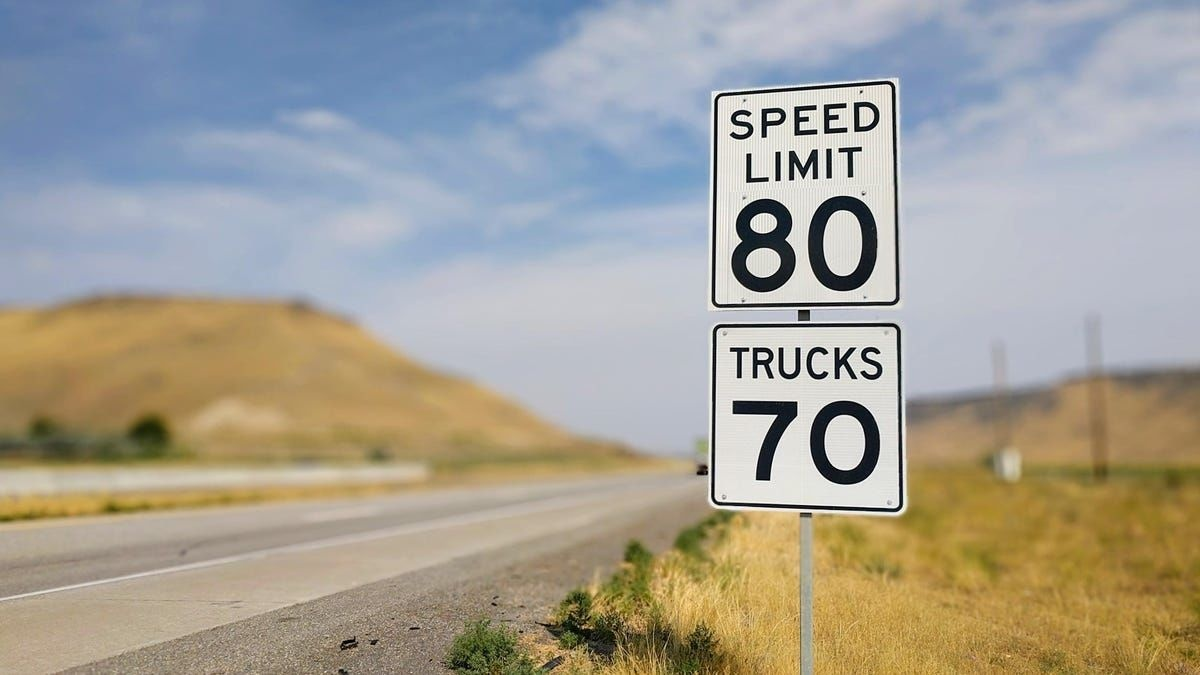

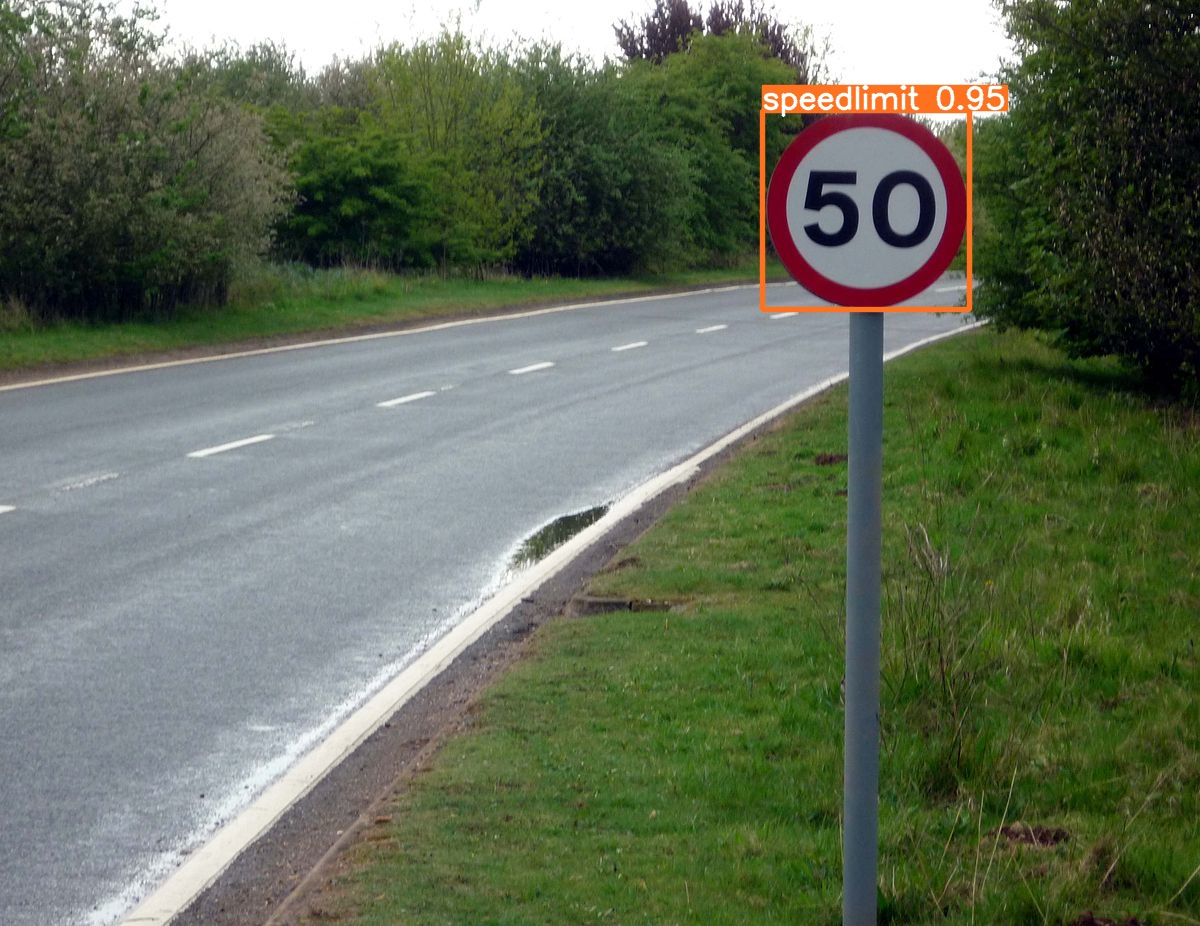

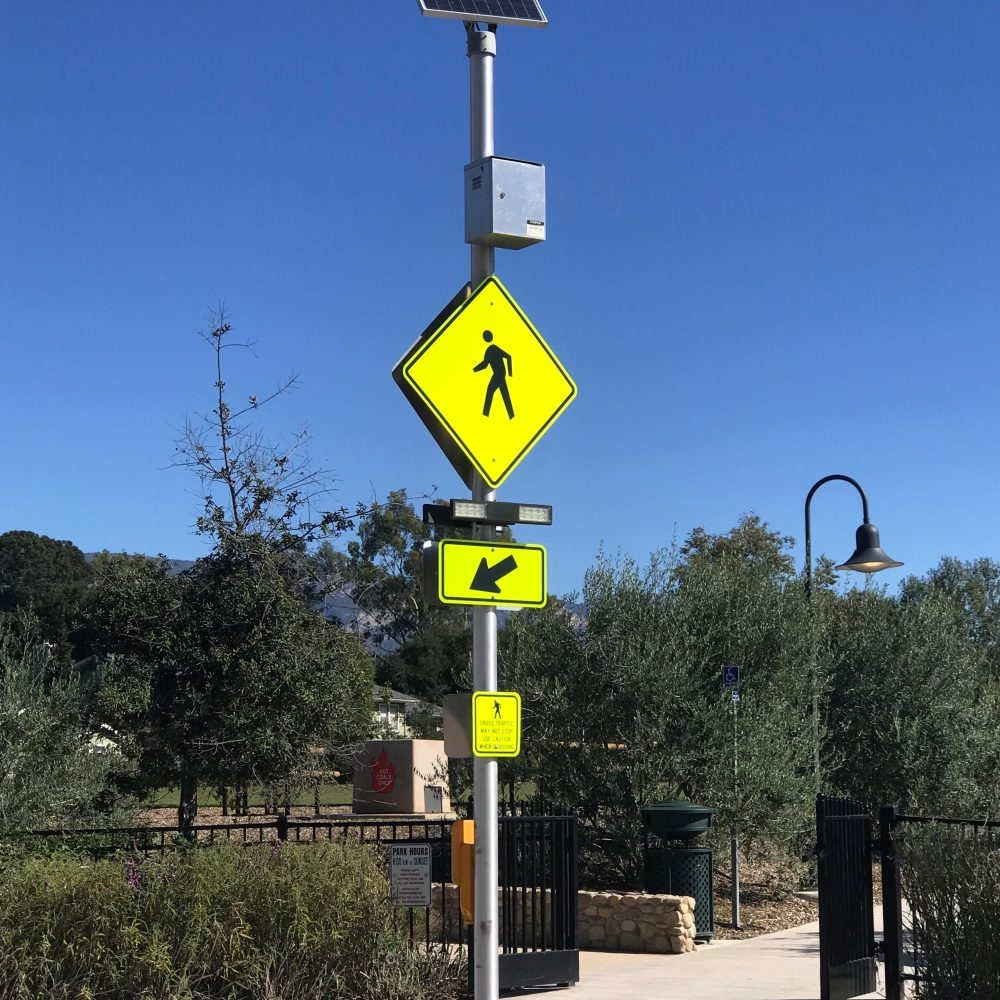

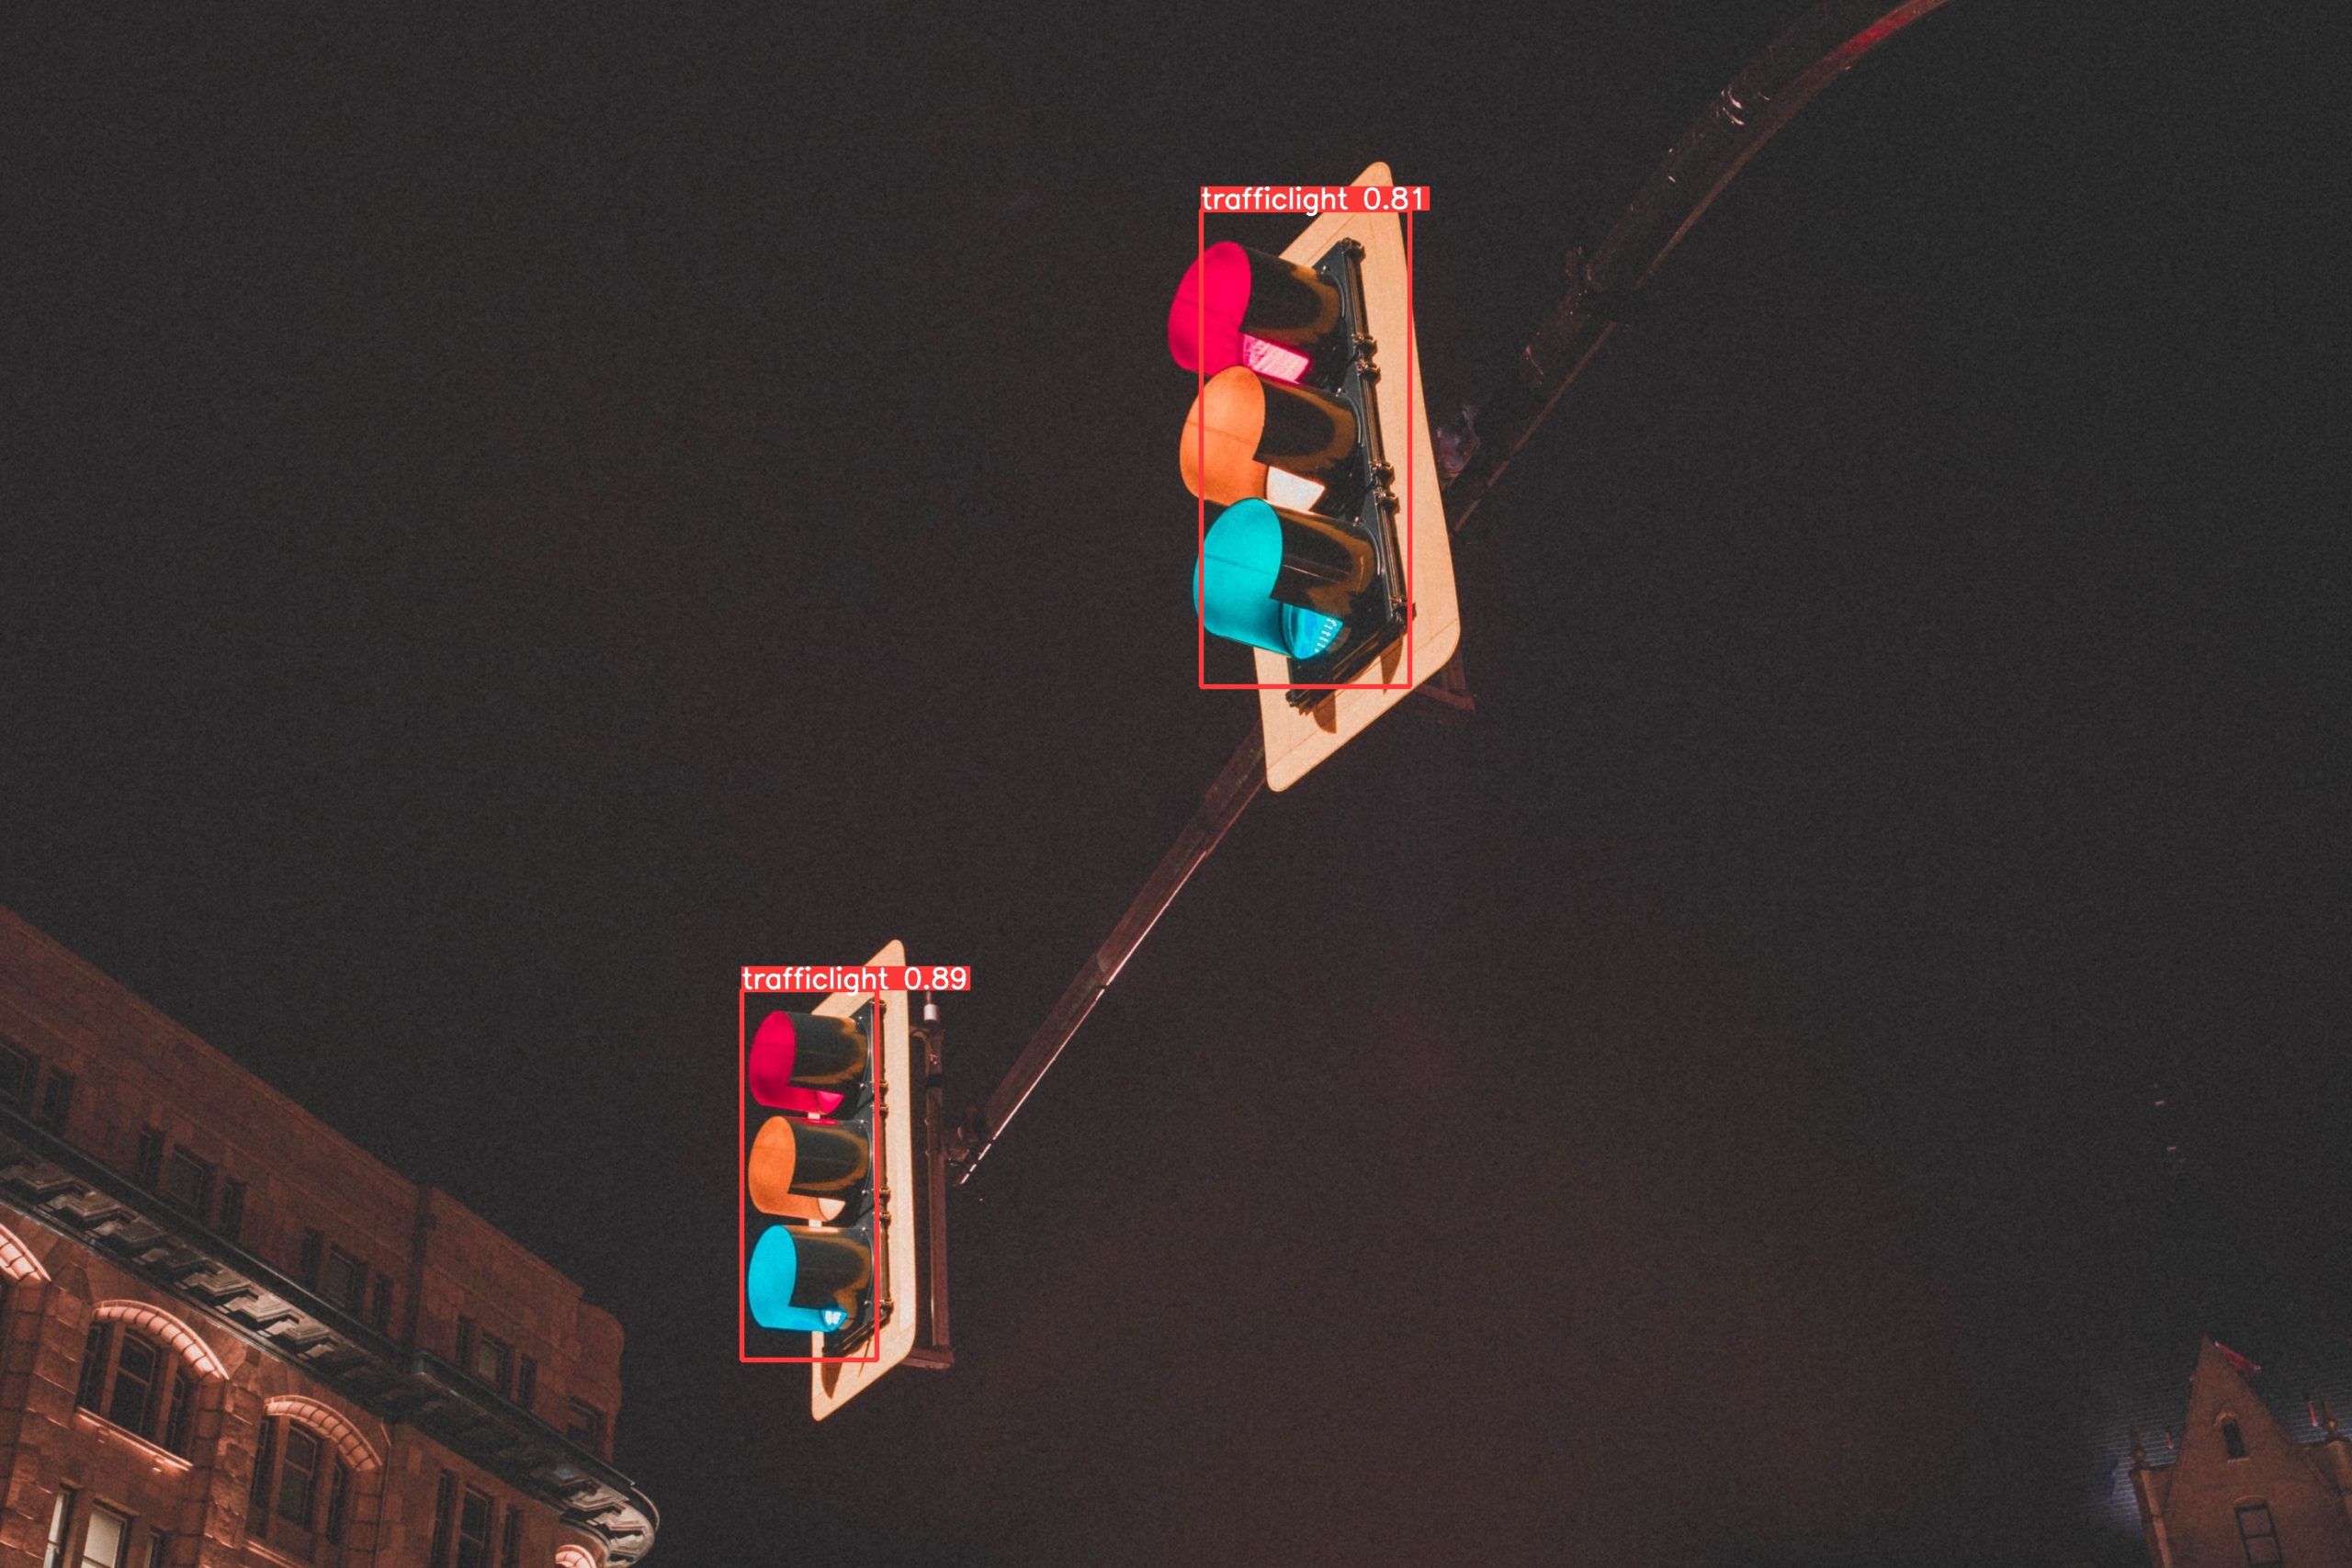

In [76]:
INFER_RESULT = os.path.join(os.getcwd(), 'runs/detect/exp2/')
images = glob.glob(f"{INFER_RESULT}/*.jpg")

for i in range(len(images)):
    display(Image(filename=images[i]))

The results show that the model consistently detect objects with high confidence. Similarly to the previous detection result, the model failed to recognized the speed limit sign in the third image but able to detect the other speed limit sign with high confidence. Compared to the previous detection result, this model unable to detect the crosswalk sign. Overall, the inference results are better than the previous one, but it may require a more varied dataset to improve detection of different signs.